In [721]:
#Basic Packages
import pandas as pd
pd.options.display.max_rows = 100
import numpy as np

#Visualization Packages
from  matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# sns.set((rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'}))

#system and db packages
import os
import pyodbc
import textwrap
import time


## Note this query is for operated wells only
`and WMDV.operated_class = 'OP'`

In [722]:
#alternate query using unit_name ONLY

sql = textwrap.dedent("""
SELECT
WMDV.api_10,
WMDV.well_name,
WMDV.sh_latitude_nad27 as lat, 
WMDV.sh_longitude_nad27 as lon,
FROM_TIMESTAMP(prod.production_date, 'yyyy-MM') as production_date,
WMDV.operated_class,
WMDV.state,
WMDV.zone,
WMDV.initial_reservoir_pressure,
WMDV.formation_volume_factor_oil,
WMDV.bulk_volume_hydrocarbon_height,
CAST(WMDV.completed_lateral_length_ft as BIGINT) as completed_lateral_length,
WMDV.water_saturation,
CAST(prod.monthly_oil as BIGINT) as monthly_oil,
CAST(prod.monthly_gas as BIGINT) as monthly_gas,
CAST(prod.monthly_water as BIGINT) as monthly_water,
CAST(prod.monthly_liquid as BIGINT) as monthly_liquid,
CAST(prod.cum_oil as BIGINT) as cum_oil,
CAST(prod.cum_water as BIGINT) as cum_water,
CAST(prod.monthly_gas * 1000 / nullifzero(prod.monthly_oil) as BIGINT) as monthly_gor,
prod.monthly_water / nullifzero(prod.monthly_liquid) as monthly_wc,
CAST(WMDV.proppant_lb_per_ft as BIGINT) as subject_prop_per_ft, 
CAST(WMDV.fluid_bbl_per_ft as BIGINT) as subject_fluid_per_ft,
CAST(WMDV.stimulated_stages as BIGINT) as subject_stages,
di.allzonespacingstatusflag as subject_gen,
STRLEFT(di.allzonennprimapi14, 10) as prim_nn_api, 
CAST(di.allzonennprimtruedistmean  as BIGINT) as prim_nn_true_dist, 
FROM_TIMESTAMP(di.allzonennprimfirstproddate, 'yyyy-MM') as prim_nn_prod_date, 
STRLEFT(di.allzonennsecapi14, 10) as sec_nn_api, 
CAST(di.allzonennsectruedistmean  as BIGINT) as sec_nn_true_dist,
FROM_TIMESTAMP(di.allzonennsecfirstproddate, 'yyyy-MM') as sec_nn_prod_date
--CAST(di.allzonennsecfirstproddate as TIMESTAMP) as sec_nn_prod_date
from drilling_info.well_spacings di
INNER Join sw_reporting.vw_clr_well_master_data_view WMDV 
    on di.api10 = WMDV.api_10
INNER JOIN sw_oso.tbl_monthly_production prod
    on WMDV.api_10 = prod.api_10
where di.wellstatus like 'ACTIVE'
and WMDV.operated_class in ('OP', 'NONOP')
--and WMDV.operated_class in ('OP')
and WMDV.hole_dir like 'HORIZONTAL'
and WMDV.major like 'OIL'
and prod.production_date > WMDV.orig_first_prod_date
and WMDV.state in ('NORTH DAKOTA', 'MONTANA')
and (WMDV.zone like ('%BAKKEN%') OR  WMDV.zone like ('%FORK%'))
ORDER BY 1, 5
""")

In [723]:
#set up server connection

pyodbc.autocommit=True

cnxn = pyodbc.connect("DSN=Impala", autocommit=True)

#Create a cursor from the connection
cursor = cnxn.cursor()

In [724]:
t0 = time.time()
df = pd.read_sql(sql, cnxn, )
t1 = time.time()

print("query took", t1-t0, "seconds")


query took 59.33929634094238 seconds


In [725]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564044 entries, 0 to 564043
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   api_10                          564044 non-null  object 
 1   well_name                       564044 non-null  object 
 2   lat                             564044 non-null  float64
 3   lon                             564044 non-null  float64
 4   production_date                 564044 non-null  object 
 5   operated_class                  564044 non-null  object 
 6   state                           564044 non-null  object 
 7   zone                            564044 non-null  object 
 8   initial_reservoir_pressure      555597 non-null  float64
 9   formation_volume_factor_oil     555304 non-null  float64
 10  bulk_volume_hydrocarbon_height  555597 non-null  float64
 11  completed_lateral_length        563292 non-null  float64
 12  water_saturation

In [726]:
df.tail()

,api_10,well_name,lat,lon,production_date,operated_class,state,zone,initial_reservoir_pressure,formation_volume_factor_oil,...,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,subject_gen,prim_nn_api,prim_nn_true_dist,prim_nn_prod_date,sec_nn_api,sec_nn_true_dist,sec_nn_prod_date
564039,3310505584,GO-SOINE A-156-97-2932H-2,48.314272,-103.167655,2021-12,NONOP,NORTH DAKOTA,MIDDLE BAKKEN,7170.686363,1.971554,...,1366.0,29.0,25.0,child,3310505583,360.0,2021-07,3310505134,697.0,2020-01
564040,3310505585,GO-BRAATEN-LW-156-97-2833H-1,48.314272,-103.167384,2021-09,NONOP,NORTH DAKOTA,MIDDLE BAKKEN,7109.643710,1.968974,...,1297.0,29.0,25.0,child,3310505582,398.0,2021-07,3310505583,529.0,2021-07
564041,3310505585,GO-BRAATEN-LW-156-97-2833H-1,48.314272,-103.167384,2021-10,NONOP,NORTH DAKOTA,MIDDLE BAKKEN,7109.643710,1.968974,...,1297.0,29.0,25.0,child,3310505582,398.0,2021-07,3310505583,529.0,2021-07
564042,3310505585,GO-BRAATEN-LW-156-97-2833H-1,48.314272,-103.167384,2021-11,NONOP,NORTH DAKOTA,MIDDLE BAKKEN,7109.643710,1.968974,...,1297.0,29.0,25.0,child,3310505582,398.0,2021-07,3310505583,529.0,2021-07
564043,3310505585,GO-BRAATEN-LW-156-97-2833H-1,48.314272,-103.167384,2021-12,NONOP,NORTH DAKOTA,MIDDLE BAKKEN,7109.643710,1.968974,...,1297.0,29.0,25.0,child,3310505582,398.0,2021-07,3310505583,529.0,2021-07


In [727]:
#Reformat alldates to same format
df['production_date'] = pd.to_datetime(df['production_date'], format = '%Y-%m')
df['prim_nn_prod_date'] = pd.to_datetime(df['prim_nn_prod_date'], format = '%Y-%m')
df['sec_nn_prod_date'] = pd.to_datetime(df['sec_nn_prod_date'], format = '%Y-%m')

# df['production_date'] = df['production_date'].dt.strftime('%Y-%m-%d')
# df['prim_nn_prod_date'] = df['prim_nn_prod_date'].dt.strftime('%Y-%m-%d')
# df['sec_nn_true_dist'] = df['sec_nn_true_dist'].dt.strftime('%Y-%m-%d')


In [728]:
df.isnull().sum()

api_10                                 0
well_name                              0
lat                                    0
lon                                    0
production_date                        0
operated_class                         0
state                                  0
zone                                   0
initial_reservoir_pressure          8447
formation_volume_factor_oil         8740
bulk_volume_hydrocarbon_height      8447
completed_lateral_length             752
water_saturation                    8447
monthly_oil                           37
monthly_gas                         2674
monthly_water                         37
monthly_liquid                        37
cum_oil                                0
cum_water                              0
monthly_gor                        35643
monthly_wc                         31454
subject_prop_per_ft                 4610
subject_fluid_per_ft               13057
subject_stages                     71652
subject_gen     

In [729]:

na_filter = df['monthly_liquid'].isnull() | df['monthly_gor'].isnull() | df['monthly_wc'].isnull()

prod_filter = (df['monthly_oil'] > 0) | (df['monthly_gas'] > 0) | (df['monthly_water'] > 0)



In [730]:
#Apply filters to discard null and negative production values and ratios
df =  df.iloc[np.where(na_filter ==False) or np.where(prod_filter)]

In [731]:
df.isnull().sum()

api_10                                 0
well_name                              0
lat                                    0
lon                                    0
production_date                        0
operated_class                         0
state                                  0
zone                                   0
initial_reservoir_pressure          7638
formation_volume_factor_oil         7923
bulk_volume_hydrocarbon_height      7638
completed_lateral_length             692
water_saturation                    7638
monthly_oil                            0
monthly_gas                            0
monthly_water                          0
monthly_liquid                         0
cum_oil                                0
cum_water                              0
monthly_gor                            0
monthly_wc                             0
subject_prop_per_ft                 3831
subject_fluid_per_ft               11418
subject_stages                     66508
subject_gen     

In [732]:
df['api_10'].nunique()

5822

In [733]:
#Wells without BVHH
df.iloc[np.where(df['bulk_volume_hydrocarbon_height'].isnull())]['well_name'].nunique()

72

In [775]:
#Wells without stage count
df.iloc[np.where(df['subject_stages'].isnull())]['well_name'].nunique()

389

In [776]:
df['state'].unique()

array(['MONTANA', 'NORTH DAKOTA'], dtype=object)

In [735]:
df['subject_gen'].unique()

array(['parent', 'standalone', 'parent/child', 'none', 'child'],
      dtype=object)

In [736]:
#Note all standalone wells have NaN distances
d_filter = df['prim_nn_true_dist'].isnull() & df['sec_nn_true_dist'].isnull()

df.iloc[np.where(d_filter)]['subject_gen'].unique()

array(['standalone'], dtype=object)

In [737]:
from sklearn.base import BaseEstimator, TransformerMixin

In [739]:
class OutlierReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, window, scale):
        self.window = window
        self.scale = scale
    
    def fit(self, X, y=None):
        
        # Split dataset between numeric and non numeric

        self.filter_df = X.select_dtypes(include= np.number).dropna(how = 'all', axis = 1)
        self.remaining_df = X.select_dtypes(exclude = np.number)
        self.missing_cols_ = set(X.columns) - set(self.filter_df.columns) - set(self.remaining_df.columns)
        self.missing_df = X[self.missing_cols_]
        self.rolling_mean = self.filter_df.rolling(window=self.window).mean()


        # Calculate confidence intervals for smoothed values
        
        mae = np.absolute(self.filter_df[self.window:] - self.rolling_mean[self.window:]).sum() / self.filter_df.shape[0]
        deviation = np.std(self.filter_df[self.window:] - self.rolling_mean[self.window:])
        lower_limit = self.rolling_mean - (mae + self.scale * deviation)
        upper_limit = self.rolling_mean + (mae + self.scale * deviation)

        #Define location of True values that  will be replaced
        ind_lower = self.filter_df < lower_limit
        ind_upper= self.filter_df > upper_limit

        self.indx_lower = [(i, j) for i,j in zip(np.where(ind_lower)[0],np.where(ind_lower)[1])]
        self.indx_upper = [(i, j) for i,j in zip(np.where(ind_upper)[0],np.where(ind_upper)[1])]
        
        return self
    
    def transform(self, X):
        Xt = self.filter_df.copy()
        for i,j in self.indx_lower:
            Xt.iloc[i,j] = self.rolling_mean.iloc[i,j]
        for i,j in self.indx_upper:
            Xt.iloc[i,j] = self.rolling_mean.iloc[i,j]
        X_ = pd.concat([self.remaining_df, Xt, self.missing_df], axis=1)
        return X_

The following transformer takes a dataframe containing column names `'prim_nn_true_dist'`, `'sec_nn_true_dist'`, and fills null values with the value indicated for `default_d` doesnothing if columns already contain values

In [740]:
class DistanceReplacer(BaseEstimator, TransformerMixin):
    #d1 and d2 are column names indicating distances to offset wells
    def __init__(self, d1 = 'prim_nn_true_dist', d2 = 'sec_nn_true_dist', default_d = 2640):
        self.d1 = d1
        self.d2 = d2
        self.default_d = default_d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = X[[self.d1, self.d2]].copy()
        Xt.fillna(self.default_d, inplace = True)
        X = X.drop([self.d1, self.d2], axis = 1)
        X = X.assign(prim_nn_true_dist = Xt[self.d1].values, sec_nn_true_dist = Xt[self.d2].values)
      
        return X

The following transformer takes a dataframe containing column names `'prim_nn_true_dist'`, `'sec_nn_true_dist'`, and calculates the allocated volume based on the area to the neighboring wells. Does nothing if columns already contain values

In [741]:
class InplaceVolumes(BaseEstimator, TransformerMixin):
    #d1 and d2 are column names indicating distances to offset wells
    def __init__(self, d1 = 'prim_nn_true_dist', d2 = 'sec_nn_true_dist',
                 bvhh = 'bulk_volume_hydrocarbon_height', ll = 'completed_lateral_length', bo = 'formation_volume_factor_oil', 
                 default_d = 2640):
        self.d1 = d1
        self.d2 = d2
        self.bvhh = bvhh
        self.ll = ll
        self.bo = bo
        self.default_d = default_d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = X[[self.d1, self.d2, self.bvhh, self.ll, self.bo]].copy()
        Xt.fillna(self.default_d, axis = 1, inplace = True)
        X = X.assign(prim_nn_vol = Xt[self.d1].values * Xt[self.ll].values *  Xt[self.bvhh].values * 0.178108 / Xt[self.bo].values,
                     sec_nn_vol = Xt[self.d2].values  * Xt[self.ll].values *  Xt[self.bvhh].values * 0.178108 / Xt[self.bo].values)
      
        return X

The following transformer takes a dataframe containing coordinates with column names `lat`, `lon`, and applies transformations to restrict the dataset to wells within a given radius from a reference coordinate

In [742]:
#Note X might need to be restricted in size due to memory
class RadiusSelector(BaseEstimator, TransformerMixin):
    def __init__(self, coord, radius, column_names = ['lat', 'lon']):
        self.coord = coord
        self.radius = radius
        self.column_names = column_names
        
    def fit(self, X, y = None):
        ref_pt = np.array(self.coord).reshape(-1, 2)
        self.ref_array = np.ones((X.shape[0])).reshape(-1, 1)*ref_pt      
        return self

    def transform(self, X):
        from sklearn.metrics.pairwise import haversine_distances
        Xt = X.copy().loc[:, self.column_names]
        R = 3958.8   #radius of the Earth in miles
        d = haversine_distances(np.radians(self.ref_array), np.radians(Xt))*R
        d = d[0].reshape(-1,1)
        idx = np.where(d < self.radius)[0]
        return X.iloc[idx]

### Using a quarter moving average `window=3`, with a scale of 0.5 works best

In [743]:
from sklearn.pipeline import Pipeline
outlier = OutlierReplacer(window=3, scale=0.5)
dist = DistanceReplacer(default_d = 2640)
inplace_vol = InplaceVolumes(default_d=2640)
prepro_pipe = Pipeline([('outlier_replacer', outlier), ('distance_replacer', dist), ('calc_volumes', inplace_vol)])

In [744]:
t0 = time.time()

df_clean = prepro_pipe.fit_transform(df)

t1 = time.time()


print("operation took", t1-t0, "seconds")


operation took 4054.9398124217987 seconds


## Use the following cell to manually verify `OutlierReplacer`

In [746]:
# example = df.query(f"`api_10` == '3310501986'")
# example.isnull().sum()

# filter_df = example.select_dtypes(include= np.number).dropna(how = 'all', axis = 1)
# remaining_df = example.select_dtypes(exclude = np.number)
# missing_cols = set(example.columns) - set(filter_df.columns) - set(remaining_df.columns)
# missing_df = example[missing_cols]


# from sklearn.metrics import mean_absolute_error
# window = 6
# scale = 0.5

# rolling_mean = filter_df.rolling(window=window).mean()


# # Plot confidence intervals for smoothed values
# mae = np.absolute(filter_df[window:] - rolling_mean[window:]).sum() / filter_df.shape[0]
# # mae = mean_absolute_error(filter_df[window:], rolling_mean[window:])
# deviation = np.std(filter_df[window:] - rolling_mean[window:])
# lower_limit = rolling_mean - (mae + scale * deviation)
# upper_limit = rolling_mean + (mae + scale * deviation)

# #True needs to be exluded
# ind_lower = filter_df < lower_limit
# ind_upper= filter_df > upper_limit

# indx_lower = [(i, j) for i,j in zip(np.where(ind_lower)[0],np.where(ind_lower)[1])]
# indx_upper = [(i, j) for i,j in zip(np.where(ind_upper)[0],np.where(ind_upper)[1])]

# Xt = filter_df.copy()
# for i,j in indx_lower:
#     Xt.iloc[i,j] = rolling_mean.iloc[i,j]
# for i,j in indx_upper:
#     Xt.iloc[i,j] = rolling_mean.iloc[i,j]
    
# example_ = pd.concat([remaining_df, Xt, missing_df], axis=1)

In [747]:
# plt.figure(figsize= (12,8))
# plt.plot(example['monthly_gor'], 'ro', label = 'original data')
# plt.plot(upper_limit['monthly_gor'], 'k--', label = 'Upper Limit')
# plt.plot(lower_limit['monthly_gor'], 'k--', label = 'Lower Limit')
# plt.plot(example_['monthly_gor'], 'r--', label = 'corrected data')
# plt.xlim(83150, 83200)
# plt.legend();

In [748]:
# plt.figure(figsize= (12,8))
# plt.plot(example['monthly_wc'], 'bo', label = 'original data')
# plt.plot(upper_limit['monthly_wc'], 'k--', label = 'Upper Limit')
# plt.plot(lower_limit['monthly_wc'], 'k--', label = 'Lower Limit')
# plt.plot(example_['monthly_wc'], 'b--', label = 'corrected data')
# plt.legend();

In [777]:
example = df.query(f"`well_name` == 'KOALA 9-5-6-12H3'")

example_2 = df_clean.query(f"`well_name` == 'KOALA 9-5-6-12H3'")

# example_2 =  prepro_pipe.fit_transform(example)

# example_2.to_csv('NORMAN 11-4MBH_.csv')

example_2.head()

,api_10,well_name,production_date,operated_class,state,zone,subject_gen,prim_nn_api,prim_nn_prod_date,sec_nn_api,...,cum_water,monthly_gor,monthly_wc,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,prim_nn_true_dist,sec_nn_true_dist,prim_nn_vol,sec_nn_vol
225067,3305303283,KOALA 9-5-6-12H3,2011-05-01,NONOP,NORTH DAKOTA,THREE FORKS 1,parent,3305304360,2013-07-01,3305306881,...,114256.666667,1519.0,0.388663,269.333333,6.0,23.333333,640.0,764.0,2.085465e+06,2.489524e+06
225068,3305303283,KOALA 9-5-6-12H3,2011-06-01,NONOP,NORTH DAKOTA,THREE FORKS 1,parent,3305304360,2013-07-01,3305306881,...,71608.000000,1434.0,0.380770,294.666667,7.0,22.666667,592.0,834.0,1.672589e+06,2.356316e+06
225069,3305303283,KOALA 9-5-6-12H3,2011-07-01,NONOP,NORTH DAKOTA,THREE FORKS 1,parent,3305304360,2013-07-01,3305306881,...,38465.000000,1453.0,0.324894,320.000000,8.0,22.000000,544.0,904.0,1.301970e+06,2.163568e+06
225070,3305303283,KOALA 9-5-6-12H3,2011-08-01,NONOP,NORTH DAKOTA,THREE FORKS 1,parent,3305304360,2013-07-01,3305306881,...,45900.000000,1452.0,0.298967,320.000000,8.0,22.000000,544.0,904.0,1.301970e+06,2.163568e+06
225071,3305303283,KOALA 9-5-6-12H3,2011-09-01,NONOP,NORTH DAKOTA,THREE FORKS 1,parent,3305304360,2013-07-01,3305306881,...,50364.000000,1646.0,0.321359,320.000000,8.0,22.000000,544.0,904.0,1.301970e+06,2.163568e+06


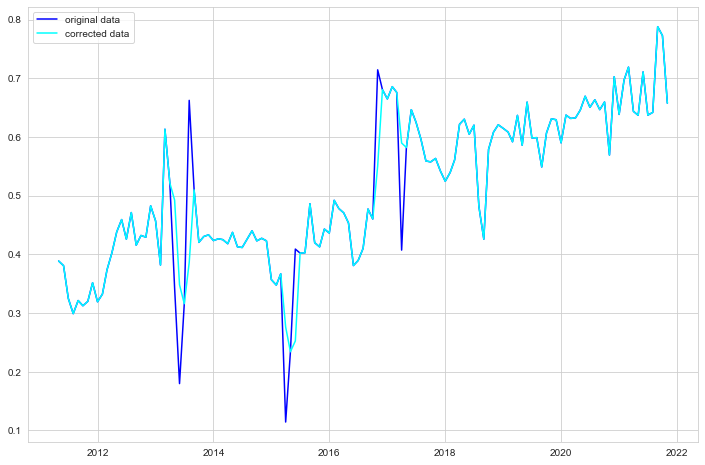

In [779]:
plt.figure(figsize= (12,8))
plt.plot(example['production_date'], example['monthly_wc'], 'b-', label = 'original data')
plt.plot(example_2['production_date'], example_2['monthly_wc'], '-', color = 'aqua', label = 'corrected data')
# plt.plot(example_2['production_date'], example_2['monthly_gor'], '.', color = 'greenyellow', label = 'corrected data')
plt.legend();

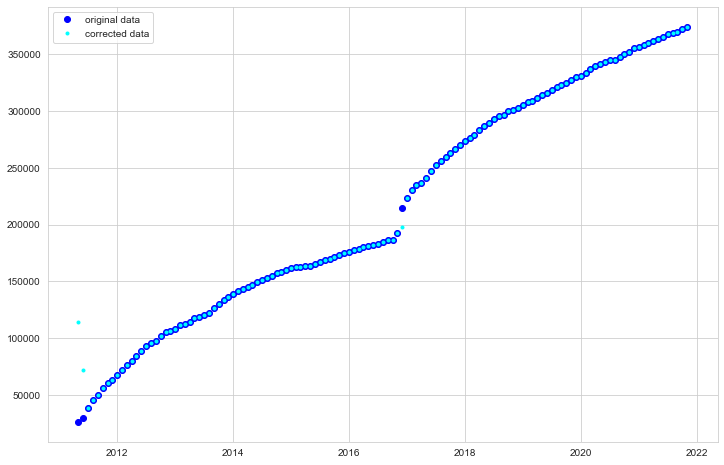

In [780]:
plt.figure(figsize= (12,8))
plt.plot(example['production_date'], example['cum_water'], 'bo', label = 'original data')
plt.plot(example_2['production_date'], example_2['cum_water'], '.', color = 'aqua', label = 'corrected data')
plt.xlim()
plt.legend();

### Use the following cell to manually verify workflow to calcualte volume between dates

In [753]:
# #define inputs>>> Enter api_10
# api_10 = '3305303337'
# subject = df.query(f"`api_10` == '{api_10}'")
# prim = df.query(f"`api_10` == '{prim_api}'")
# prim_api = subject['prim_nn_api'].iloc[0]

# #Determine first prod date for prim_nn
# prim_split_date = subject['prim_nn_prod_date'].iloc[0].strftime('%Y-%m-%d')

# #Determine last date
# last_date = subject['production_date'].iloc[-1].strftime('%Y-%m-%d')

# #extract cum volumes for suject well up to ref prim date
# subject_split_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==prim_split_date)[0][0]]
# subject_split_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==prim_split_date)[0][0]]

# #extract prim_nn cum to last date
# prim_cum_oil = prim['cum_oil'].iloc[np.where(prim['production_date']==last_date)[0][0]]
# prim_cum_water = prim['cum_water'].iloc[np.where(prim['production_date']==last_date)[0][0]]

# #extract subject cum to last date
# subject_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==last_date)[0][0]]
# subject_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==last_date)[0][0]]

# #calculated combined volume produced by subject and primary
# combined_prim_split_to_date_cum_oil = subject_cum_oil - subject_split_cum_oil + prim_cum_oil
# combined_prim_split_to_date_cum_water= subject_cum_water - subject_split_cum_water + prim_cum_water


In [754]:
#This well has issues

# api_10 = '3305303668'
# subject = df.query(f"`api_10` == '{api_10}'")
# subject.head()

In [755]:
# def offset_volumes(api_10, cols = ['prim_nn_api', 'sec_nn_api']):

#     #Define Volume lists
#     split_dates = []
#     pre_split_oil_cums= []
#     pre_split_water_cums= []
#     pre_split_liquid_cums = []
#     combined_oil_cums = []
#     combined_water_cums = []
#     combined_liquid_cums = []
    
#     subject = df.query(f"`api_10` == '{api_10}'")
    
#     #Determine last date
#     last_date = subject['production_date'].iloc[-1].strftime('%Y-%m-%d')
    
#     nn_lst = [subject[col].iloc[0] for col in cols if subject[col].iloc[0]!=None]
    
#     for nn_api in nn_lst:
#         nn = df.query(f"`api_10` == '{nn_api}'")
#         #Determine split date for nn
#         if subject['production_date'].iloc[0] > nn['production_date'].iloc[0]:

#             split_date = subject['production_date'].iloc[0].strftime('%Y-%m-%d')


#             #extract nn cum to split date
#             pre_split_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==split_date)[0][0]]
#             pre_split_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==split_date)[0][0]]
#             pre_split_cum_liquid = pre_split_cum_oil + pre_split_cum_water

#             #extract nn cum post split date
#             post_split_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==last_date)[0][0]] - pre_split_cum_oil
#             post_split_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==last_date)[0][0]] - pre_split_cum_water
#             post_split_cum_liquid = post_split_cum_oil + post_split_cum_water

#             #extract subject cum to last date
#             subject_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==last_date)[0][0]]
#             subject_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==last_date)[0][0]]


#             #calculated combined volume produced by subject and nn
#             combined_cum_oil = subject_cum_oil + post_split_cum_oil
#             combined_cum_water= subject_cum_water + post_split_cum_water
#             combined_cum_liquid = combined_cum_oil + combined_cum_water
            
#         else:    # when subject['production_date'].iloc[0] < nn['production_date'].iloc[0]
# #         elif subject['production_date'].iloc[0] < nn['production_date'].iloc[0]:

#             split_date = nn['production_date'].iloc[0].strftime('%Y-%m-%d')

#             #extract cum to split date
#             pre_split_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==split_date)[0][0]]
#             pre_split_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==split_date)[0][0]]
#             pre_split_cum_liquid = pre_split_cum_oil + pre_split_cum_water
            

#             #extract nn cum post split date
#             post_split_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==last_date)[0][0]] - pre_split_cum_oil
#             post_split_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==last_date)[0][0]] - pre_split_cum_water
#             post_split_cum_liquid = post_split_cum_oil + post_split_cum_water

#             #extract nn cum to last date
#             nn_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==last_date)[0][0]]
#             nn_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==last_date)[0][0]]

#             #calculated combined volume produced by subject and nn
#             combined_cum_oil = nn_cum_oil + post_split_cum_oil
#             combined_cum_water= nn_cum_water + post_split_cum_water
#             combined_cum_liquid = combined_cum_oil + combined_cum_water
            
#         split_dates.append(split_date)    
#         pre_split_oil_cums.append(pre_split_cum_oil)
#         pre_split_water_cums.append(pre_split_cum_water)
#         combined_oil_cums.append(combined_cum_oil)
#         combined_water_cums.append(combined_cum_water)
#         pre_split_liquid_cums.append(pre_split_cum_liquid)
#         combined_liquid_cums.append(combined_cum_liquid)
                
#     return (split_dates, pre_split_liquid_cums, combined_liquid_cums)

### The following funtion will determine the split volume between subject and nn wells

In [757]:
def offset_volumes_2(df, api_10, cols = ['prim_nn_api', 'sec_nn_api'], return_value = None):

    #Define Volume lists
    split_dates = []
    pre_split_oil_cums= []
    pre_split_water_cums= []
    pre_split_liquid_cums = []
    post_split_oil_cums= []
    post_split_water_cums= []
    post_split_liquid_cums = []
    combined_oil_cums = []
    combined_water_cums = []
    combined_liquid_cums = []
    
    subject = df.query(f"`api_10` == '{api_10}'")
    
    #Determine last date
    last_date = subject['production_date'].iloc[-1].strftime('%Y-%m-%d')
    nn_lst =[subject[col].iloc[0] for col in cols if not df.query(f"`api_10` == '{subject[col].iloc[0]}'").empty]
    
    for nn_api in nn_lst:
        nn = df.query(f"`api_10` == '{nn_api}'")
        #Determine split date for nn
        if subject['production_date'].iloc[0] > nn['production_date'].iloc[0]:

            split_date = subject['production_date'].iloc[0].strftime('%Y-%m-%d')
            
            #extract cum to split date
            #handling exception error in case of gaps between last date of nn and subject well
            try:
                pre_split_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==split_date)[0][0]]
                pre_split_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==split_date)[0][0]]
                pre_split_cum_liquid = pre_split_cum_oil + pre_split_cum_water
            except IndexError:
                while IndexError:
                    i = 1
                    pre_split_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']== subject['production_date'].iloc[i].strftime('%Y-%m-%d'))[0][0]]
                    pre_split_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==subject['production_date'].iloc[i].strftime('%Y-%m-%d'))[0][0]]
                    pre_split_cum_liquid = pre_split_cum_oil + pre_split_cum_water
                    if pre_split_cum_oil > 1 and pre_split_cum_water>1:
                        break
                    else:
                        i=+1


            #extract nn cum post split date
            post_split_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==last_date)[0][0]] - pre_split_cum_oil
            post_split_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==last_date)[0][0]] - pre_split_cum_water
            post_split_cum_liquid = post_split_cum_oil + post_split_cum_water

            #extract subject cum to last date
            subject_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==last_date)[0][0]]
            subject_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==last_date)[0][0]]


            #calculated combined volume produced by subject and nn
            combined_cum_oil = subject_cum_oil + post_split_cum_oil
            combined_cum_water= subject_cum_water + post_split_cum_water
            combined_cum_liquid = combined_cum_oil + combined_cum_water
            
        else:# subject['production_date'].iloc[0] < nn['production_date'].iloc[0]:

            split_date = nn['production_date'].iloc[0].strftime('%Y-%m-%d')

            #extract cum to split date
            #handling exception error in case of gaps between last date of prod and offset well
            try:
                pre_split_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==split_date)[0][0]]
                pre_split_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==split_date)[0][0]]
                pre_split_cum_liquid = pre_split_cum_oil + pre_split_cum_water
            except IndexError:
                while IndexError:
                    i = 1
                    pre_split_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date'] == prim['production_date'].iloc[i].strftime('%Y-%m-%d'))[0][0]]
                    pre_split_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==prim['production_date'].iloc[i].strftime('%Y-%m-%d'))[0][0]]
                    pre_split_cum_liquid = pre_split_cum_oil + pre_split_cum_water
                    if pre_split_cum_oil > 1 and pre_split_cum_water>1:
                        break
                    else:
                        i=+1


            
            #extract subject cum post split date
            post_split_cum_oil = subject['cum_oil'].iloc[np.where(subject['production_date']==last_date)[0][0]] - pre_split_cum_oil
            post_split_cum_water = subject['cum_water'].iloc[np.where(subject['production_date']==last_date)[0][0]] - pre_split_cum_water
            post_split_cum_liquid = post_split_cum_oil + post_split_cum_water

            #extract nn cum to last date
            nn_cum_oil = nn['cum_oil'].iloc[np.where(nn['production_date']==last_date)[0][0]]
            nn_cum_water = nn['cum_water'].iloc[np.where(nn['production_date']==last_date)[0][0]]
            

            #calculated combined volume produced by subject and nn
            combined_cum_oil = nn_cum_oil + post_split_cum_oil
            combined_cum_water= nn_cum_water + post_split_cum_water
            combined_cum_liquid = combined_cum_oil + combined_cum_water
            

            
        split_dates.append(split_date)    
        
        pre_split_oil_cums.append(pre_split_cum_oil)
        pre_split_water_cums.append(pre_split_cum_water)
        pre_split_liquid_cums.append(pre_split_cum_liquid)
        
        post_split_oil_cums.append(post_split_cum_oil)
        post_split_water_cums.append(post_split_cum_water)
        post_split_liquid_cums.append(post_split_cum_liquid)
        
        combined_oil_cums.append(combined_cum_oil)
        combined_water_cums.append(combined_cum_water)
        combined_liquid_cums.append(combined_cum_liquid)
                
#     return split_dates
    if return_value =='split_dates':
        return split_dates
    elif return_value =='pre_split_oil_cums':
        return pre_split_oil_cums
    elif return_value =='pre_split_water_cums':
        return pre_split_water_cums
    elif return_value =='pre_split_liquid_cums':
        return pre_split_liquid_cums
    
    elif return_value =='post_split_oil_cums':
        return post_split_oil_cums
    elif return_value =='post_split_water_cums':
        return post_split_water_cums
    elif return_value =='post_split_liquid_cums':
        return post_split_liquid_cums
    
    elif return_value =='combined_oil_cums':
        return combined_oil_cums
    elif return_value =='combined_water_cums':
        return combined_water_cums
    elif return_value =='combined_liquid_cums':
        return combined_liquid_cums
    else:
        return 'please enter correct metric'   

In [758]:
#Manual Checks used to debugg from cells 692 to cell 705

# OK    3310501986
# OK    3305303211
# OK    3302501186
# OK    3305303903
# OK    3302500768

# OK    3305304237
# OK     2508322664

# OK    3305304258
# OK    3310503136


In [759]:
#define inputs>>> Enter api_10
api_10 = '3305306825'
subject = df.query(f"`api_10` == '{api_10}'")

prim_api = subject['prim_nn_api'].iloc[0]
prim = df.query(f"`api_10` == '{prim_api}'")

sec_api = subject['sec_nn_api'].iloc[0]

sec = df.query(f"`api_10` == '{sec_api}'")
sec_ = prepro_pipe.fit_transform(sec)

In [760]:
subject.head(1)

,api_10,well_name,lat,lon,production_date,operated_class,state,zone,initial_reservoir_pressure,formation_volume_factor_oil,...,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,subject_gen,prim_nn_api,prim_nn_true_dist,prim_nn_prod_date,sec_nn_api,sec_nn_true_dist,sec_nn_prod_date
374323,3305306825,GUDMUNSON 1-1-26MBH,47.873614,-103.061849,2017-02-01,NONOP,NORTH DAKOTA,MIDDLE BAKKEN,7192.379779,2.044566,...,814.0,24.0,22.0,child,3305306826,449.0,2016-11-01,3305304847,716.0,2013-05-01


In [761]:
prim_api

'3305306826'

In [762]:
sec_api

'3305304847'

In [763]:
sec.head(1) #raw -->correct Api

,api_10,well_name,lat,lon,production_date,operated_class,state,zone,initial_reservoir_pressure,formation_volume_factor_oil,...,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,subject_gen,prim_nn_api,prim_nn_true_dist,prim_nn_prod_date,sec_nn_api,sec_nn_true_dist,sec_nn_prod_date
301905,3305304847,GUDMUNSON 11-26TFH,47.875654,-103.06423,2013-07-01,NONOP,NORTH DAKOTA,THREE FORKS 1,7169.687844,2.042353,...,357.0,8.0,30.0,parent/child,3305306824,565.0,2016-11-01,3305306825,805.0,2016-11-01


In [764]:
sec_.head(1) #transformed from raw

,api_10,well_name,production_date,operated_class,state,zone,subject_gen,prim_nn_api,prim_nn_prod_date,sec_nn_api,...,cum_water,monthly_gor,monthly_wc,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,prim_nn_true_dist,sec_nn_true_dist,prim_nn_vol,sec_nn_vol
301905,3305304847,GUDMUNSON 11-26TFH,2013-07-01,NONOP,NORTH DAKOTA,THREE FORKS 1,parent/child,3305306824,2016-11-01,3305306825,...,5421.0,38071.0,0.0,357.0,8.0,30.0,565.0,805.0,1.547430e+06,2.204745e+06


In [765]:
sec_['cum_water'].head()

301905     5421.000000
301906     5421.000000
301907     7530.666667
301908     9640.333333
301909    14373.666667
Name: cum_water, dtype: float64

In [766]:
sec['cum_water'].head()

301905     5421
301906     5421
301907    11750
301908    11750
301909    19621
Name: cum_water, dtype: int64

In [767]:
# parent_df = prepro_pipe.fit_transform(df.query(f"`subject_gen` == 'parent'"))

In [768]:
import datetime

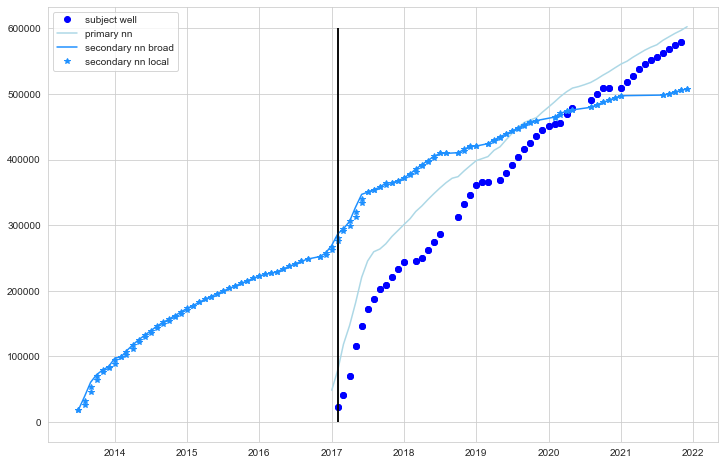

In [769]:
plt.figure(figsize= (12,8))
plt.plot(subject['production_date'], subject['cum_oil'] + subject['cum_water'], 'bo', label = 'subject well')

plt.plot(prim['production_date'], prim['cum_oil'] + prim['cum_water'], '-', color = 'lightblue', label = 'primary nn')
prim_date = offset_volumes_2(df, api_10, return_value='split_dates')[0]
plt.vlines(x = datetime.datetime.strptime(prim_date,'%Y-%m-%d'), ymin=0, ymax=600000, colors='black')

plt.plot(sec['production_date'], sec['cum_oil'] + sec['cum_water'], '-', color = 'dodgerblue', label = 'secondary nn broad')
plt.plot(sec_['production_date'], sec_['cum_oil'] + sec_['cum_water'], '*', color = 'dodgerblue', label = 'secondary nn local')
sec_date = offset_volumes_2(df, api_10, return_value='split_dates')[1]
plt.vlines(x = datetime.datetime.strptime(sec_date,'%Y-%m-%d'), ymin=0, ymax=600000, colors='black')

# plt.ylim(0, 1.1 * prim['cum_oil'].max())
plt.legend(loc = 'upper left');

In [773]:
offset_volumes_2(df_clean, api_10, return_value='split_dates')

['2017-02-01', '2017-02-01']

In [774]:
offset_volumes_2(df_clean, api_10, return_value='pre_split_liquid_cums')

[235840.0, 287116.0]

In [720]:
offset_volumes_2(df_clean, api_10, return_value='combined_liquid_cums')

[1095640, 797178]

### Note: if there are significant differences bettween the GOR behaviour associated with `subject_gen` categories then we could potentially encode them an use them as features

In [781]:

# Create a subsets for each class

parent_df = df_clean.query(f"`subject_gen` == 'parent'")


alone_df = df_clean.query(f"`subject_gen` == 'standalone'")



child_df = df_clean.query(f"`subject_gen` == 'child'")



parent_child_df = df_clean.query(f"`subject_gen` == 'parent/child'")



## Parent Well Case

In [782]:
parent_df['api_10'].sample(5)

226794    3305303305
248575    3305303697
200507    3305302999
19944     2508322537
249686    3305303741
Name: api_10, dtype: object

## Child Well Case

In [783]:
child_df['api_10'].sample(5)

511410    3310503040
185150    3303300303
292379    3305304637
527036    3310503405
407475    3305308714
Name: api_10, dtype: object

## Parent/Child Well Case

In [784]:
parent_child_df['api_10'].sample(5)

30109     2508322778
259743    3305303959
366550    3305306504
41969     2508323102
389754    3305307787
Name: api_10, dtype: object

In [101]:
test_group = child_df.groupby('api_10')

In [119]:
test_group.ngroups

2181

In [117]:
X = pd.DataFrame()
for api in test_group.groups:
    row = test_group.get_group(api).head(1)
    X = X.append(row)
    
    

In [123]:
X.head()

,api_10,well_name,production_date,operated_class,state,zone,subject_gen,prim_nn_api,prim_nn_prod_date,sec_nn_api,...,cum_water,monthly_gor,monthly_wc,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,prim_nn_true_dist,sec_nn_true_dist,prim_nn_vol,sec_nn_vol
13560,2508322365,TWYLA 1-31H,2006-01-01,OP,MONTANA,MIDDLE BAKKEN,child,2508322279,2005-05-01,None,...,19361.333333,0.0,0.121789,43.000000,1.000000,NaN,2066.000000,2640.0,1.468520e+06,1.876522e+06
21148,2508322558,BR 21-33H 52,2007-02-01,NONOP,MONTANA,MIDDLE BAKKEN,child,2508322426,2006-07-01,None,...,881.000000,0.0,0.297396,144.000000,1.000000,NaN,1495.666667,2640.0,1.234261e+06,2.178593e+06
22389,2508322587,CANDEE 2-18H,2007-04-01,OP,MONTANA,MIDDLE BAKKEN,child,2508322448,2006-05-01,None,...,4996.000000,758.0,0.153004,137.000000,1.000000,NaN,1744.000000,2640.0,8.801232e+05,1.332297e+06
23920,2508322605,MARGARET 3-15H,2007-05-01,OP,MONTANA,MIDDLE BAKKEN,child,2508322008,2003-11-01,2508322192,...,34089.666667,103.0,0.170764,139.666667,1.333333,NaN,1087.000000,1939.0,5.938527e+05,1.059320e+06
25467,2508322629,BETTYE 2-26H,2007-11-01,OP,MONTANA,MIDDLE BAKKEN,child,2508322141,2004-05-01,None,...,3928.000000,372.0,0.328234,101.666667,1.333333,NaN,1589.000000,2640.0,1.339227e+06,2.225022e+06


In [128]:
X['api_10'].apply(lambda x: x)

13560     2508322365
21148     2508322558
22389     2508322587
23920     2508322605
25467     2508322629
             ...    
564015    3310505451
564024    3310505575
564033    3310505583
564037    3310505584
564040    3310505585
Name: api_10, Length: 2181, dtype: object

In [131]:
offset_volumes('2508322365', return_value='pre_split_liquid_cums')

IndexError: single positional indexer is out-of-bounds

In [126]:
X['api_10'].apply(lambda x: offset_volumes(x, return_value='pre_split_liquid_cums'))

IndexError: single positional indexer is out-of-bounds

In [93]:
pd.Series(offset_volumes(api_10, return_value='pre_split_liquid_cums'))

0    164272
1    141571
dtype: int64

In [1241]:
alone_df['well_name'].nunique()

317

In [179]:
df['bulk_volume_hydrocarbon_height'].describe()

count    519764.000000
mean          2.935175
std           1.014668
min           0.465854
25%           2.211538
50%           3.015746
75%           3.753475
max           5.385008
Name: bulk_volume_hydrocarbon_height, dtype: float64

In [1262]:
#We have 22 wells with no res pressure
alone_df.iloc[np.where(alone_df['bulk_volume_hydrocarbon_height'].isnull())]['well_name'].nunique()

22

In [1265]:
alone_df.iloc[np.where(alone_df['subject_fluid_per_ft'].isnull())]

,api_10,well_name,production_date,operated_class,state,zone,subject_gen,lat,lon,initial_reservoir_pressure,...,monthly_gas,monthly_water,monthly_liquid,monthly_gor,monthly_wc,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,prim_nn_true_dist,sec_nn_true_dist
14573,2508322542,AZALEA 1-6H,2007-02-01,OP,MONTANA,MIDDLE BAKKEN,standalone,47.892311,-104.650296,5373.967349,...,614.333333,280.833333,1268.500000,444.0,0.216761,76.333333,NaN,NaN,2640.0,2640.0
14574,2508322542,AZALEA 1-6H,2007-03-01,OP,MONTANA,MIDDLE BAKKEN,standalone,47.871669,-104.686273,5291.670540,...,1106.333333,834.000000,2372.666667,543.0,0.217355,67.666667,NaN,NaN,2640.0,2640.0
14575,2508322542,AZALEA 1-6H,2007-04-01,OP,MONTANA,MIDDLE BAKKEN,standalone,47.851026,-104.722249,5209.373732,...,2421.000000,509.000000,4682.000000,580.0,0.193778,59.000000,NaN,NaN,2640.0,2640.0
14576,2508322542,AZALEA 1-6H,2007-05-01,OP,MONTANA,MIDDLE BAKKEN,standalone,47.830383,-104.758226,5127.076923,...,2065.000000,340.000000,3594.000000,635.0,0.171496,50.333333,NaN,NaN,2640.0,2640.0
14577,2508322542,AZALEA 1-6H,2007-06-01,OP,MONTANA,MIDDLE BAKKEN,standalone,47.809741,-104.794203,5044.780115,...,2443.833333,735.000000,4676.000000,1118.0,0.157252,33.000000,NaN,NaN,2640.0,2640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164455,3310501756,HEIDI 1-4H,2021-06-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,standalone,48.357626,-103.414891,7644.523878,...,1230.000000,1234.000000,2032.000000,1542.0,0.607522,409.000000,NaN,17.0,2640.0,2640.0
164456,3310501756,HEIDI 1-4H,2021-07-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,standalone,48.357626,-103.414891,7644.523878,...,1301.000000,1107.000000,1790.000000,1905.0,0.618262,409.000000,NaN,17.0,2640.0,2640.0
164457,3310501756,HEIDI 1-4H,2021-08-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,standalone,48.357626,-103.414891,7644.523878,...,1293.000000,1090.000000,1746.000000,1971.0,0.624373,409.000000,NaN,17.0,2640.0,2640.0
164458,3310501756,HEIDI 1-4H,2021-09-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,standalone,48.357626,-103.414891,7644.523878,...,1506.000000,1140.000000,1832.000000,2177.0,0.622283,409.000000,NaN,17.0,2640.0,2640.0


In [1147]:
'33025007360000\n33025009240000'.split('\n')

['33025007360000', '33025009240000']

In [1149]:
'33025007360000'.rstrip('0000')

'3302500736'

In [1161]:
#Paste api's from excel here
refrac_apis = ["""
33025007360000
33025009240000
33025016180000
33025028660000
33053032080000
33053034010000
33053035100000
33053039710100
33053042290000
33053042940000
33053043480000
33053045580000
33053046680000
33053046690000
33053046700000
33053047410000
33053047420000
33053047790000
33053047800000
33053048060100
33053048080000
33053048570000
33053048680000
33053049080000
33053049090000
33053049100000
33053051140000
33053051150000
33053051160100
33053051170000
33053052500000
33053055040000
33053055200000
33053055230000
33053055240000
33053055250000
33053059730000
33053059740000
33053059750000
"""]

refrac_apis = [api.splitlines() for api in refrac_apis][0][1:-1]
# refrac_apis = [api.split('\n') for api in refrac_apis][0][1:-1]
refrac_api_10 = [api.rstrip('0000') for api in refrac_apis]

In [1250]:
rf_example = df.query(f"`api_10` == '3302500745'")
rf_example.tail()

,api_10,well_name,lat,lon,production_date,operated_class,state,zone,initial_reservoir_pressure,formation_volume_factor_oil,...,monthly_water,monthly_liquid,monthly_gor,monthly_wc,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,subject_gen,prim_nn_true_dist,sec_nn_true_dist
83186,3302500745,RODNEY 1-29H,47.51726,-102.934018,2021-05-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,8195.793969,1.606749,...,0.0,0.0,0.0,0.0,650.0,15.0,NaN,parent,310.0,454.0
83189,3302500745,RODNEY 1-29H,47.51726,-102.934018,2021-07-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,8195.793969,1.606749,...,0.0,0.0,57763.0,0.0,650.0,15.0,NaN,parent,310.0,454.0
83190,3302500745,RODNEY 1-29H,47.51726,-102.934018,2021-07-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,8195.793969,1.606749,...,0.0,0.0,57763.0,0.0,650.0,15.0,NaN,parent,310.0,454.0
83195,3302500745,RODNEY 1-29H,47.51726,-102.934018,2021-10-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,8195.793969,1.606749,...,0.0,285.0,0.0,0.0,650.0,15.0,NaN,parent,310.0,454.0
83196,3302500745,RODNEY 1-29H,47.51726,-102.934018,2021-10-01,OP,NORTH DAKOTA,MIDDLE BAKKEN,8195.793969,1.606749,...,0.0,285.0,0.0,0.0,650.0,15.0,NaN,parent,310.0,454.0


In [1251]:
refrac_case =  prepro_pipe.fit_transform(rf_example)

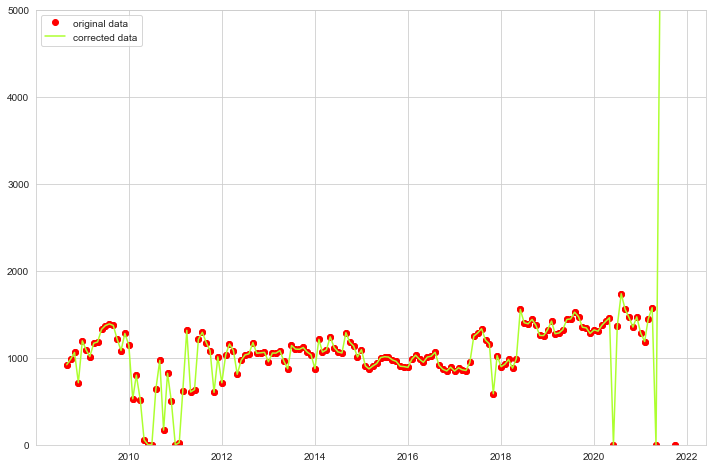

In [1252]:
plt.figure(figsize= (12,8))
plt.plot(rf_example['production_date'], rf_example['monthly_gor'], 'ro', label = 'original data')
plt.plot(refrac_case['production_date'], refrac_case['monthly_gor'], '-', color = 'greenyellow', label = 'corrected data')
plt.ylim(0,5000)
plt.legend();

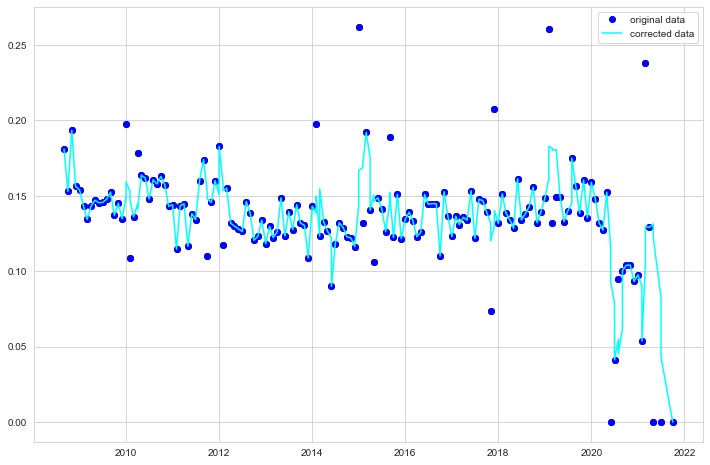

In [1253]:
plt.figure(figsize= (12,8))
plt.plot(rf_example['production_date'], rf_example['monthly_wc'], 'bo', label = 'original data')
plt.plot(refrac_case['production_date'], refrac_case['monthly_wc'], '-', color = 'aqua', label = 'corrected data')
plt.legend();

In [28]:
montana_df = df.query(f"`state` == 'MONTANA'")
ndakota_df = df.query(f"`state` == 'NORTH DAKOTA'")

In [29]:
dist = RadiusSelector(coord  = (47.544785, -102.90146)  , radius=3) #HAWKINSON 1-22H
dist.fit(ndakota_df)

RadiusSelector(coord=(47.544785, -102.90146), radius=3)

In [1254]:
# hawk_df = dist.transform(ndakota_df)
# hawk_df['well_name'].unique()

In [679]:
'MemoryError: Unable to allocate 39.6 GiB for an array with shape (33639, 157892) and data type float64'

'MemoryError: Unable to allocate 39.6 GiB for an array with shape (33639, 157892) and data type float64'

In [16]:
df.query(f"`well_name` == 'LCU JESSIE 2-24H1'")['monthly_oil']

200194    37916.0
200195    46193.0
200196    42526.0
200197    28860.0
200198     8740.0
200199     9060.0
200200    14710.0
Name: monthly_oil, dtype: float64

In [674]:
montana_df.query(f"`well_name` == 'DEVIN 1-13H'").head(1)

,api_10,well_name,lat,lon,production_date,operated_class,state,zone,monthly_oil,monthly_gas,monthly_water,monthly_liquid,monthly_gor,monthly_wc,subject_prop_per_ft,subject_fluid_per_ft,subject_stages,subject_gen,prim_nn_true_dist,sec_nn_true_dist
22678,2508322929,DEVIN 1-13H,48.01208,-104.81997,2013-01-01,OP,MONTANA,MIDDLE BAKKEN,509.0,470.0,0.0,509.0,924.0,0.0,293.0,6.0,30.0,standalone,NaN,NaN


In [596]:
montana_df['well_name'].nunique()

286

In [600]:
# coord  = (48.01208,-104.81997) 
# column_names = ['lat', 'lon']
# radius = 5
# Xt = montana_df.copy().loc[:, column_names]

# ref_pt = np.array(coord).reshape(-1, 2)
# ref_array = np.ones((Xt.shape[0])).reshape(-1, 1)*ref_pt       


# R = 3958.8   #radius of the Earth in miles
# d = haversine_distances(np.radians(ref_array), np.radians(Xt))*R
# d = d[0].reshape(-1,1)
# idx = np.where(d < radius)[0]

In [31]:
dist = RadiusSelector(coord  = (48.01208,-104.81997)  , radius=5) #DEVIN 1-13H
dist.fit(montana_df)
devin_df = dist.transform(montana_df)

In [692]:
well_menu = devin_df['well_name'].unique()
well_menu

array(['NOLA 1-22H', 'MILLICENT 1-5H', 'DUANE 1-28H', 'MARTIN 1-27H',
       'JOANN 1-32H', 'TOLKSDORF 1-1H', 'DUANE 2-28H', 'DENMAN 1-7H',
       'DAVIES 1-20H', 'SLOCUM 1-8H', 'FARNSWORTH 1-18H', 'GORMAN 1-11H',
       'KANE 1-10H', 'DEVIN 1-13H', 'EGAN 1-14H', 'COOPER 1-10H',
       'HITCHCOCK 1-9H', 'MOTT 1-16H', 'TOWER 1-4H', 'BUTTERFIELD 1-26H',
       'ENGLISH FEDERAL 1-5H', 'BAIRD 1-34H', 'FISHER 1-29H',
       'MONA 1-29H', 'HARRIS 1-20H', 'CHARLIE 3-5H', 'CHARLIE 2-5H',
       'BAIRD FEDERAL 2-34H'], dtype=object)

In [693]:
from ipywidgets import widgets


def plot_feature(well):
    ex = devin_df.query(f"`well_name` == '{well}'")
    plt.ylim(0, 5000)
    plt.plot(ex['production_date'], ex['monthly_gor'], 'o', label = well)
    plt.xlabel('Date')
    plt.ylabel('Gas Oil Ratio')
    plt.legend()

widgets.interact(plot_feature, well=well_menu);

interactive(children=(Dropdown(description='well', options=('NOLA 1-22H', 'MILLICENT 1-5H', 'DUANE 1-28H', 'MA…

In [694]:
from ipywidgets import widgets


def plot_feature(well):
    ex = devin_df.query(f"`well_name` == '{well}'")
    plt.ylim(0, 1)
    plt.plot(ex['production_date'], ex['monthly_wc'], 'o', label = well)
    plt.xlabel('Date')
    plt.ylabel('Water Cut')
    plt.legend()

widgets.interact(plot_feature, well=well_menu);

interactive(children=(Dropdown(description='well', options=('NOLA 1-22H', 'MILLICENT 1-5H', 'DUANE 1-28H', 'MA…

In [695]:
# plt.figure(figsize = (10,8))
# plt.ylim(0, 3000)
# well = montana_df.query(f"`well_name` == 'DEVIN 1-13H'")
# plt.plot(well['production_date'], well['monthly_gor'], 'o');
# # plt.plot(example['monthly_liquid'].cumsum(), example['monthly_gor'].cumsum());    

## import additional metrics

In [820]:
%pwd

'Y:\\My Simulations\\Notebooks\\Spacing'

In [821]:
rf_df = pd.read_excel("Y:\\My Simulations\\Notebooks\\Spacing\\Data\\North_RF_Results_FINAL 10-8-21.xlsx", sheet_name='Final Master - By Unit')

In [822]:
rf_df = rf_df[rf_df.columns[:-6]]

In [823]:
rf_df.isnull().sum()

UNIT_ID                                         0
SURFACE_ID                                      1
UNIT_NAME                                     609
FORMATION                                       0
STATE                                           0
AREA                                            0
PROJECT                                        42
DISTRICT                                        0
OPERATOR                                      442
OP_NONOP_NOINT                                  0
UNIT_GROSS_ACRES                                0
CENTER_X                                        0
CENTER_Y                                        0
DEV_WELLS                                       0
UNDEV_WELLS                                     0
TOTAL_WELLS                                     0
BHP                                             0
Pbp                                             6
BHT                                             0
Bo                                            273


In [824]:
rf_df = rf_df.iloc[np.where(rf_df['Bo'].isnull()==False)]

In [825]:
rf_df = rf_df.iloc[np.where(rf_df['TF2_FZU_BVHH'].isnull()==False)]

In [826]:
rf_df.isnull().sum()

UNIT_ID                                        0
SURFACE_ID                                     0
UNIT_NAME                                     54
FORMATION                                      0
STATE                                          0
AREA                                           0
PROJECT                                        0
DISTRICT                                       0
OPERATOR                                      49
OP_NONOP_NOINT                                 0
UNIT_GROSS_ACRES                               0
CENTER_X                                       0
CENTER_Y                                       0
DEV_WELLS                                      0
UNDEV_WELLS                                    0
TOTAL_WELLS                                    0
BHP                                            0
Pbp                                            0
BHT                                            0
Bo                                             0
Gas_Gravity         

In [827]:
rf_df['SURFACE_ID'].nunique()

1199

In [828]:
rf_df.head()

,UNIT_ID,SURFACE_ID,UNIT_NAME,FORMATION,STATE,AREA,PROJECT,DISTRICT,OPERATOR,OP_NONOP_NOINT,...,OOIP Total Unit,OOIP MB + TF1,OWIP Total Unit,OWIP MB + TF1,MB OLIP,TF1 OLIP,TF2 OLIP,Unit OLIP,MB+TF1 OLIP,Fully Developed
6343,40AC9702-B625-432B-815E-AFFB91768497,149N099W026149N099W035,BW-HEIDI-HO,THREE FORKS 1,ND,NORTH,WILLISTON SOUTH,ND BAKKEN,HESS,NOINT,...,3.154157e+07,2.734381e+07,8.080660e+07,5.097009e+07,2.578204e+07,5.253186e+07,3.403427e+07,1.123482e+08,7.831390e+07,Y
6344,ACB9D700-6B3F-4457-91DF-9E1E0E61F226,149N099W026149N099W035,BW-HEIDI-HO,MIDDLE BAKKEN,ND,NORTH,WILLISTON SOUTH,ND BAKKEN,HESS,NOINT,...,3.154157e+07,2.734381e+07,8.080660e+07,5.097009e+07,2.578204e+07,5.253186e+07,3.403427e+07,1.123482e+08,7.831390e+07,Y
6345,424A1EDD-866E-400B-931B-1F52429C5289,149N099W026149N099W035,BW-HEIDI-HO,THREE FORKS 2,ND,NORTH,WILLISTON SOUTH,ND BAKKEN,HESS,NOINT,...,3.154157e+07,2.734381e+07,8.080660e+07,5.097009e+07,2.578204e+07,5.253186e+07,3.403427e+07,1.123482e+08,7.831390e+07,Y
6346,4A367983-F5DE-45DB-8A86-F179AB43109B,149N099W014149N099W023,BW-KRAETSC,THREE FORKS 2,ND,NORTH,WILLISTON SOUTH,ND BAKKEN,HESS,NOINT,...,3.270738e+07,2.833613e+07,8.370228e+07,5.056637e+07,2.814388e+07,5.075863e+07,3.750715e+07,1.164097e+08,7.890250e+07,Y
6347,9FA5100E-9965-49C9-885E-D585A92B10BB,149N099W014149N099W023,BW-KRAETSC,THREE FORKS 1,ND,NORTH,WILLISTON SOUTH,ND BAKKEN,HESS,NOINT,...,3.270738e+07,2.833613e+07,8.370228e+07,5.056637e+07,2.814388e+07,5.075863e+07,3.750715e+07,1.164097e+08,7.890250e+07,Y


In [829]:
rf_df.columns.str.lower()

Index(['unit_id', 'surface_id', 'unit_name', 'formation', 'state', 'area',
       'project', 'district', 'operator', 'op_nonop_noint', 'unit_gross_acres',
       'center_x', 'center_y', 'dev_wells', 'undev_wells', 'total_wells',
       'bhp', 'pbp', 'bht', 'bo', 'gas_gravity', 'gor', 'avg gor (eur)',
       'oil_gravity', 'delta_p_pbp', 'sum gross eur oil', 'm_bkkn_h',
       'm_bkkn_phi', 'm_bkkn_sw', 'tf1_h', 'tf1_phi', 'tf1_sw', 'tf2_h',
       'tf2_phi', 'tf2_sw', 'l_bkkn_perm', 'm_bkkn_perm', 'tf1_perm',
       'u_bkkn_perm', 'm_bkkn_fzu_bvhh', 'tf1_fzu_bvhh', 'tf2_fzu_bvhh',
       'm_bkkn_fzu_bvwh', 'tf1__fzu_bvwh', 'tf2_fzu_bvwh', 'm_bkkn_fzu_owip',
       'tf1_fzu_owip', 'tf2_fzu_owip', 'ooip mb per unit (calc from this ss)',
       'ooip mb per unit (from adj ooip new fzu)',
       'ooip tf1 per unit (calc from this ss)',
       'ooip tf2 per unit (calc from this ss)', 'ooip total unit',
       'ooip mb + tf1', 'owip total unit', 'owip mb + tf1', 'mb olip',
       'tf1 olip',

In [830]:
rf_df.columns

Index(['UNIT_ID', 'SURFACE_ID', 'UNIT_NAME', 'FORMATION', 'STATE', 'AREA',
       'PROJECT', 'DISTRICT', 'OPERATOR', 'OP_NONOP_NOINT', 'UNIT_GROSS_ACRES',
       'CENTER_X', 'CENTER_Y', 'DEV_WELLS', 'UNDEV_WELLS', 'TOTAL_WELLS',
       'BHP', 'Pbp', 'BHT', 'Bo', 'Gas_Gravity', 'GOR', 'Avg GOR (EUR)',
       'Oil_Gravity', 'Delta_P_Pbp', 'Sum Gross EUR Oil', 'M_BKKN_H',
       'M_BKKN_PHI', 'M_BKKN_Sw', 'TF1_H', 'TF1_PHI', 'TF1_Sw', 'TF2_H',
       'TF2_PHI', 'TF2_Sw', 'L_BKKN_PERM', 'M_BKKN_PERM', 'TF1_PERM',
       'U_BKKN_PERM', 'M_BKKN_FZU_BVHH', 'TF1_FZU_BVHH', 'TF2_FZU_BVHH',
       'M_BKKN_FZU_BVWH', 'TF1__FZU_BVWH', 'TF2_FZU_BVWH', 'M_BKKN_FZU_OWIP',
       'TF1_FZU_OWIP', 'TF2_FZU_OWIP', 'OOIP MB per unit (Calc from this ss)',
       'OOIP MB per unit (from Adj OOIP new FZU)',
       'OOIP TF1 per unit (Calc from this ss)',
       'OOIP TF2 per unit (Calc from this ss)', 'OOIP Total Unit',
       'OOIP MB + TF1', 'OWIP Total Unit', 'OWIP MB + TF1', 'MB OLIP',
       'TF1 OLIP',

In [831]:
# export datafram and target for Chris and Sabby

# rf_df[['STATE', 'AREA','PROJECT','BHP', 'Pbp', 'BHT']].groupby('PROJECT').agg('mean').to_excel("Y:\\My Simulations\\Notebooks\\Spacing\\Data\\avg_pressures_by_area.xlsx", index=True)

# rf_df.to_excel("Y:\\My Simulations\\Notebooks\\Spacing\\Data\\North_RF_metrics_v2.xlsx", index=False)

In [832]:
exclude_cols = ['state', 'surface_id', 'well_count',
                'lat', 'lng', 'production_date',
                'monthly_oil', 'monthly_gas', 'monthly_water', 'monthly_liquid',
                'cum_liquid', 'unit_proppant_ft',
                'unit_total_proppant', 'unit_stage_count']

selected_cols = list(set(prod.columns) - set(exclude_cols))

filt_df = prod.loc[:, selected_cols]

#calculate lower and upped bounds

low = 0.05
high = 0.95

quant_df = filt_df.quantile([low, high], numeric_only = True)

#apply bounds to dataset

filt_df = filt_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

filt_df = filt_df.loc[:, selected_cols]

#return initially excluded columns
prod_ = pd.concat([prod.loc[:,exclude_cols], filt_df], axis=1)

In [833]:
prod.isnull().sum()

state                      0
surface_id               280
well_count                 0
lat                        0
lng                        0
production_date            0
monthly_oil               10
monthly_gas              838
monthly_water             10
monthly_liquid            10
cum_liquid                 0
monthly_gor             4628
monthly_wc              3572
unit_proppant_ft        1391
unit_total_proppant     1140
unit_stage_count       15754
dtype: int64

In [834]:
#filter down to units where surface_id is NOT null
prod = prod[prod['surface_id'].isnull()==False]

#filter down to units where values are possitive

prod_t = (
    prod.query('monthly_gor > 0 & monthly_wc > 0 & well_count >= 2')
    .dropna()
    .reset_index(drop=True)
)

print(prod_t.query('well_count >= 5')['surface_id'].nunique())

print(prod_t.query('well_count >= 10')['surface_id'].nunique())

466
120


In [835]:
#How many rows with zero GOR
prod_t['monthly_gor'].shape[0]- np.count_nonzero(prod_t['monthly_gor'])

0

In [836]:
#How many rows with zero GOR
prod_t['monthly_wc'].shape[0]- np.count_nonzero(prod_t['monthly_wc'])

0

In [837]:
prod_t['surface_id'].nunique()

835

Ou transfomer should:
1. groupby unit
2. Calculate a mean value for all groups
3. Return input normalized metric of first well_count

In [838]:
y = prod_t.pop('monthly_gor')

In [839]:
unit_averages = (
    prod_t
    .assign(y = y)
    .groupby(['surface_id', 'well_count'])['y']
    .mean()
)      

In [840]:
wc_means = {}
for index, value in unit_averages.groupby(level = 0):
    wc_means[index] = value[0]

wc_means

{'023N054E003024N054E034': 1284.43688876,
 '023N054E008': 1879.7300581686754,
 '023N054E010': 1303.965153976471,
 '023N054E011023N054E014': 453.5547498000002,
 '023N054E013023N054E024': 1328.528173448718,
 '023N054E018': 2319.217549770114,
 '023N055E001024N055E036': 1501.9513058571429,
 '023N055E002024N055E035': 2013.5107064941178,
 '023N055E003024N055E034': 277.994617,
 '023N055E004024N055E033': 1629.4088365794394,
 '023N055E005023N055E008': 1219.715166365672,
 '023N055E009023N055E016': 619.1496263404255,
 '023N055E011023N055E014': 1460.2067579700004,
 '023N055E020023N055E029': 934.3504776346155,
 '023N055E022023N055E027': 360.298592,
 '023N055E023023N055E026': 1479.3141389199996,
 '023N055E024023N055E025': 1207.7990417575752,
 '023N056E006024N056E031': 1574.3218121470586,
 '023N056E008023N056E017': 1152.886585230769,
 '023N056E009023N056E016': 1424.75646910204,
 '023N056E019023N056E030': 1340.3765814356427,
 '023N056E020023N056E029': 1950.7968193586953,
 '023N056E021023N056E028': 107

In [841]:
for value in unit_averages.groupby(level = 0).get_group('140N099W005140N099W008'):
    print(value)

1150.1217534
1934.0820660185188
3706.1340606226418


In [842]:
wc_means.get('140N099W005140N099W008')

1150.1217534

In [843]:
len(wc_means.keys())

835

In [844]:
len(unit_averages.groupby(level = 0))

835

In [845]:
unit_groups = (
    prod_t
    .assign(y = y)
    .groupby('surface_id')['y']
)

In [846]:
unit_groups.ngroups

835

In [847]:
norm_gor_values = {}
for surface_id in wc_means.keys():
    norm_gor_values[surface_id] = unit_groups.get_group(surface_id).apply(lambda x: x/wc_means.get(surface_id))

In [848]:
from itertools import chain

y_norm = np.array(list(chain(*norm_gor_values.values()))).reshape(-1,1)

In [849]:
y_norm.shape

(71508, 1)

In [850]:
y.shape

(71508,)

In [851]:
A = prod_t.assign(y_norm = y_norm).query("`surface_id` == '159N097W021159N097W028159N097W033'")['y_norm']

B = prod_t.assign(y=y).query("`surface_id` == '159N097W021159N097W028159N097W033'")['y'] / wc_means.get('159N097W021159N097W028159N097W033')

assert (A - B).sum() == 0

In [852]:
from sklearn.metrics import mean_absolute_error

In [853]:
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],'ko', label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [854]:
#export datafram and target for Chris

# export_df = prod_t.assign(y_norm=y_norm, y = y)

# export_df.to_excel("X:\Resource Development\Modeling\MIKEG\GOR_study\simple_metrics.xlsx", index=False)

In [855]:
units = pd.Series(prod_t.query('well_count >= 10')['surface_id'].unique())

sample = np.random.choice(units, 1)[0]

sample

'150N095W010150N095W011'

In [917]:
#max rise > 10
['149N095W016149N095W017', '151N097W003151N097W010',
       '151N098W006151N098W007', '152N095W003152N095W010',
       '152N095W015152N095W022', '152N096W005152N096W008',
       '153N091W003153N091W004153N091W009153N091W010',
       '153N094W014153N094W023', '153N095W029153N095W032',
       '154N099W013154N099W014154N099W015']

['149N095W016149N095W017',
 '151N097W003151N097W010',
 '151N098W006151N098W007',
 '152N095W003152N095W010',
 '152N095W015152N095W022',
 '152N096W005152N096W008',
 '153N091W003153N091W004153N091W009153N091W010',
 '153N094W014153N094W023',
 '153N095W029153N095W032',
 '154N099W013154N099W014154N099W015']

In [944]:
grouped_unit = prod_t.assign(y_norm=y_norm, y = y).groupby('surface_id')


prd_grp = grouped_unit.get_group(sample)

# prd_grp = grouped_unit.get_group('153N091W003153N091W004153N091W009153N091W010')


sections = prd_grp.groupby('well_count')

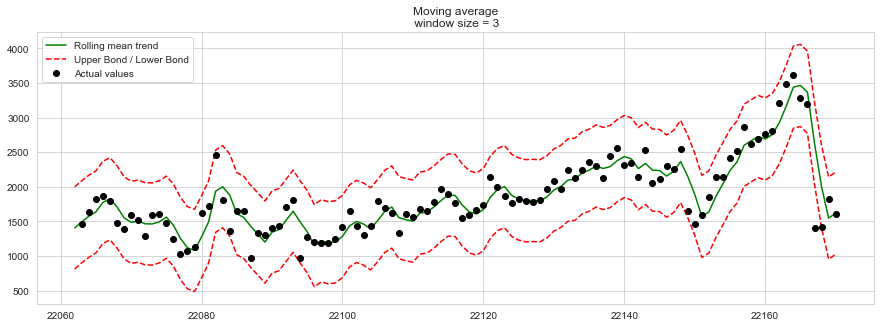

In [945]:
plotMovingAverage(prd_grp['y'], 3, plot_intervals=True)

In [946]:
prd_grp

,state,surface_id,well_count,lat,lng,production_date,monthly_oil,monthly_gas,monthly_water,monthly_liquid,cum_liquid,monthly_wc,unit_proppant_ft,unit_total_proppant,unit_stage_count,y_norm,y
22060,NORTH DAKOTA,150N095W010150N095W011,2,47.823311,-102.831636,2012-04-01,77190.0,91711.0,8799.0,85989.0,86732.0,0.102327,512.0,4642976.0,57.0,0.772697,1188.120223
22061,NORTH DAKOTA,150N095W010150N095W011,2,47.823311,-102.831636,2012-05-01,51389.0,71771.0,5770.0,57159.0,143891.0,0.100946,512.0,4642976.0,57.0,0.908297,1396.621845
22062,NORTH DAKOTA,150N095W010150N095W011,2,47.823311,-102.831636,2012-06-01,34389.0,56180.0,3453.0,37842.0,181733.0,0.091248,512.0,4642976.0,57.0,1.062456,1633.661927
22063,NORTH DAKOTA,150N095W010150N095W011,2,47.823311,-102.831636,2012-07-01,22575.0,32867.0,2411.0,24986.0,206719.0,0.096494,512.0,4642976.0,57.0,0.946850,1455.902547
22064,NORTH DAKOTA,150N095W010150N095W011,2,47.823311,-102.831636,2012-08-01,25412.0,41494.0,2355.0,27767.0,234486.0,0.084813,512.0,4642976.0,57.0,1.061929,1632.850622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22166,NORTH DAKOTA,150N095W010150N095W011,12,47.824122,-102.799506,2021-03-01,2104.0,6717.0,1264.0,3368.0,4220866.0,0.375297,2992.0,29221794.0,406.0,2.076245,3192.490494
22167,NORTH DAKOTA,150N095W010150N095W011,12,47.824122,-102.799506,2021-06-01,13556.0,18985.0,16989.0,30545.0,4251411.0,0.556196,2992.0,29221794.0,406.0,0.910810,1400.486869
22168,NORTH DAKOTA,150N095W010150N095W011,12,47.824122,-102.799506,2021-07-01,41253.0,58319.0,71469.0,112722.0,4364133.0,0.634029,2992.0,29221794.0,406.0,0.919398,1413.691125
22169,NORTH DAKOTA,150N095W010150N095W011,12,47.824122,-102.799506,2021-08-01,16287.0,29812.0,47344.0,63631.0,4427764.0,0.744040,2992.0,29221794.0,406.0,1.190417,1830.416897


In [947]:
rf_df.query("`SURFACE_ID`=='150N095W010150N095W011'")[['UNIT_NAME','FORMATION','DEV_WELLS', 'UNDEV_WELLS', 'TOTAL_WELLS']].sum()

UNIT_NAME         BB-BELQUIST BB-BELQUIST BB-BELQUIST 
FORMATION      THREE FORKS 2THREE FORKS 1MIDDLE BAKKEN
DEV_WELLS                                           12
UNDEV_WELLS                                          4
TOTAL_WELLS                                         16
dtype: object

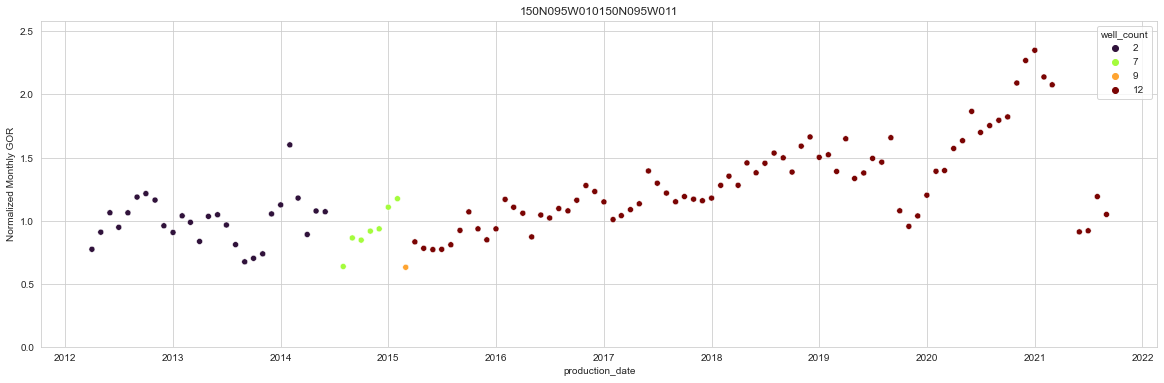

In [948]:
plt.figure(figsize = (20,6))
x_axis='production_date'
y_axis='y_norm'
y2_axis='monthly_oil'
sns.scatterplot(data=prd_grp, x= x_axis , y = y_axis, hue = 'well_count', palette='turbo')
plt.ylim(0,prd_grp[y_axis].max()*1.1)
# plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.ylabel('Normalized Monthly GOR')

# ax2 = plt.twinx()
# sns.lineplot(data=prd_grp, x= x_axis, y = y2_axis, ax=ax2,  color = 'g', style="well_count", dashes=True)
# plt.gca().invert_yaxis()
# plt.xlabel('Cumulative Liquid Produced [stb]')
# plt.ylabel('Inverse Monthly Oil rate')
# # plt.xlim(0, prd_grp[x_axis].max()*1.1)
# plt.ylim(prd_grp[y2_axis].max()*1.1, 0)
# plt.legend(loc ='upper left')
plt.title(prd_grp['surface_id'].iloc[0]);

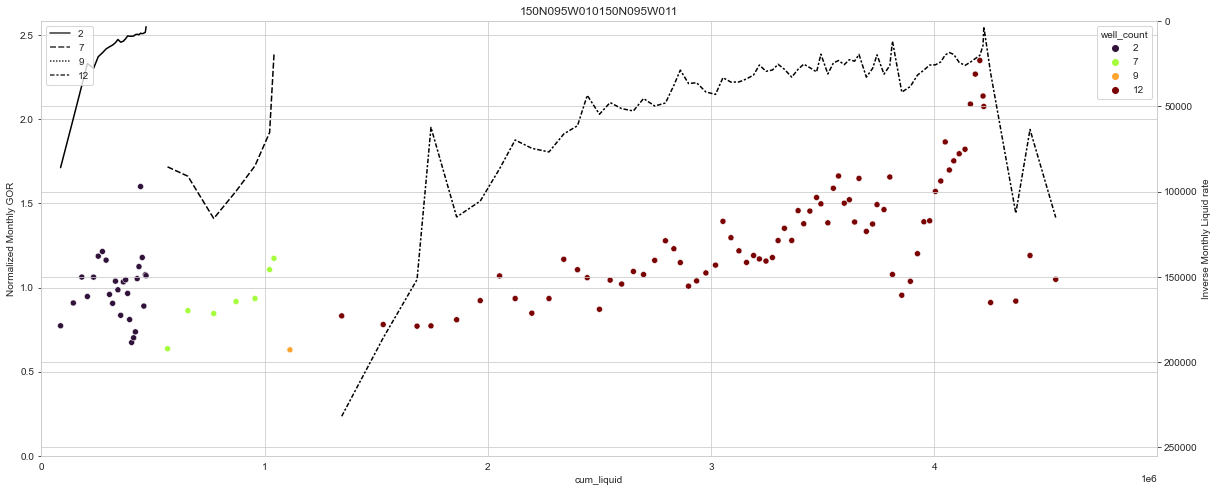

In [949]:
plt.figure(figsize = (20,8))
x_axis='cum_liquid'
y_axis='y_norm'
y2_axis='monthly_liquid'
sns.scatterplot(data=prd_grp, x= x_axis , y = y_axis, hue = 'well_count', palette='turbo')
plt.ylim(0,prd_grp[y_axis].max()*1.1)
plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.ylabel('Normalized Monthly GOR')

ax2 = plt.twinx()
sns.lineplot(data=prd_grp, x= x_axis, y = y2_axis, ax=ax2,  color = 'k', style="well_count", dashes=True)
plt.gca().invert_yaxis()
plt.xlabel('Cumulative Liquid Produced [stb]')
plt.ylabel('Inverse Monthly Liquid rate')
plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.ylim(prd_grp[y2_axis].max()*1.1, 0)
plt.legend(loc ='upper left')
plt.title(prd_grp['surface_id'].iloc[0]);

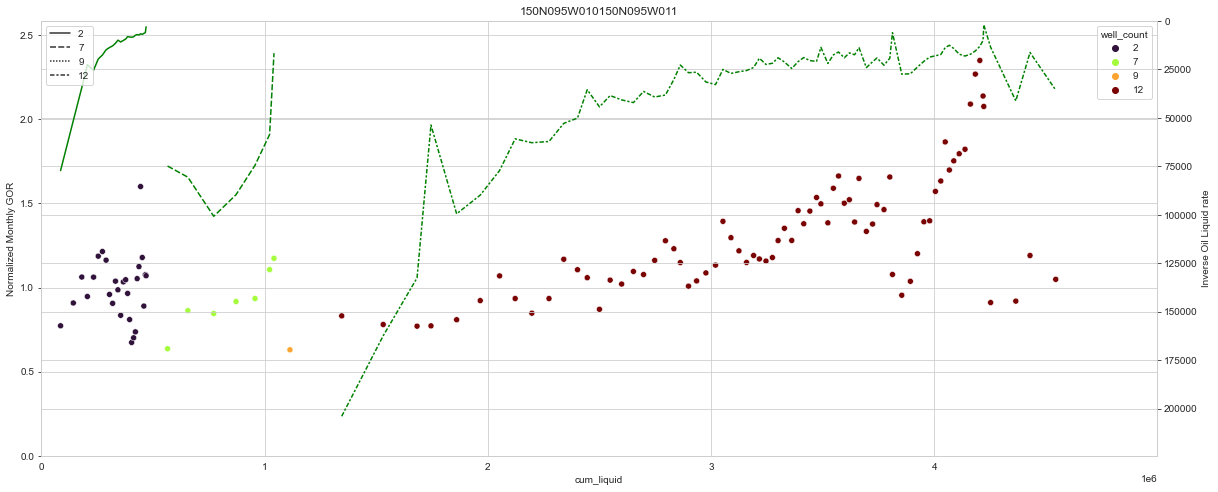

In [950]:
plt.figure(figsize = (20,8))
x_axis='cum_liquid'
y_axis='y_norm'
y2_axis='monthly_oil'
sns.scatterplot(data=prd_grp, x= x_axis , y = y_axis, hue = 'well_count', palette='turbo')
plt.ylim(0,prd_grp[y_axis].max()*1.1)
plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.ylabel('Normalized Monthly GOR')

ax2 = plt.twinx()
sns.lineplot(data=prd_grp, x= x_axis, y = y2_axis, ax=ax2,  color = 'g', style="well_count", dashes=True)
plt.gca().invert_yaxis()
plt.xlabel('Cumulative Liquid Produced [stb]')
plt.ylabel('Inverse Oil Liquid rate')
plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.ylim(prd_grp[y2_axis].max()*1.1, 0)
plt.legend(loc ='upper left')
plt.title(prd_grp['surface_id'].iloc[0]);

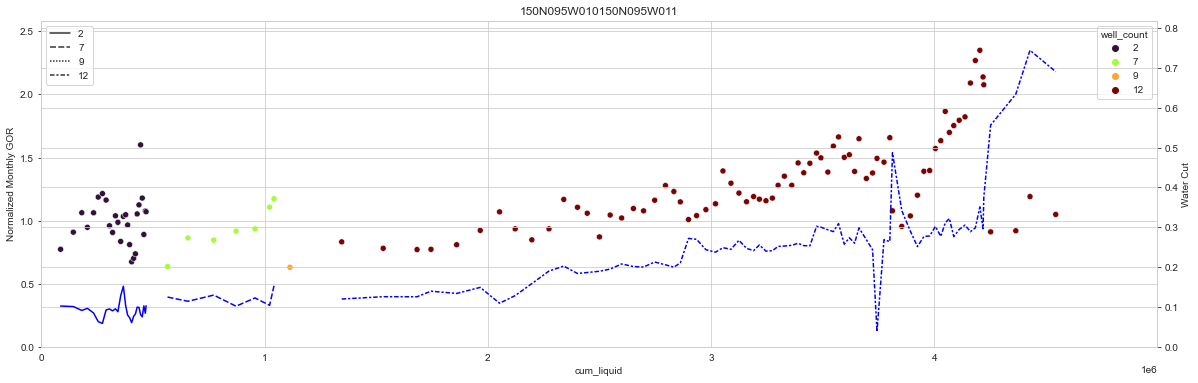

In [951]:
plt.figure(figsize = (20,6))
x_axis='cum_liquid'
y_axis='y_norm'
y2_axis='monthly_wc'
sns.scatterplot(data=prd_grp, x= x_axis , y = y_axis, hue = 'well_count', palette='turbo')
plt.ylim(0,prd_grp[y_axis].max()*1.1)
plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.ylabel('Normalized Monthly GOR')

ax2 = plt.twinx()
sns.lineplot(data=prd_grp, x= x_axis, y = y2_axis, ax=ax2,  color = 'b', style="well_count", dashes=True)
plt.xlabel('Cumulative Liquid Produced [stb]')
plt.ylabel('Water Cut')
plt.ylim(0, prd_grp[y2_axis].max()*1.1)
plt.xlim(0, prd_grp[x_axis].max()*1.1)
plt.legend(loc ='upper left')
plt.title(prd_grp['surface_id'].iloc[0]);

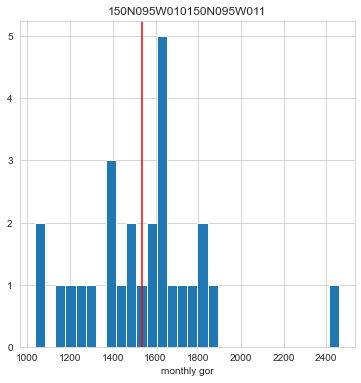

In [863]:
plt.figure(figsize = (6,6))
plt.hist(prd_grp.query('well_count < 5')['y'], bins= 30)
plt.axvline(x= wc_means.get(prd_grp['surface_id'].iloc[0]), color="red")
plt.xlabel('monthly gor')
plt.title(prd_grp['surface_id'].iloc[0]);

In [864]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [865]:
#this transformer only selects columns
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X[self.columns]

In [866]:
class DistTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, origin):
        self.origin = origin
        
    def fit(self, X, y= None):
        """
        Intemediate calculations:
        
        Here goes the code for the model to learn from the data
        In other words: here we calculate and determine model parameters
        that weill need n the transformations
        
        """
        return self
        
        
    def transform(self, X):
        """
        How we transform the data
        
        Assume that the data comes in as two columns
        where the first is lat and second is lon
        
        """
        if isinstance(X, pd.DataFrame):
            Xt = X.values
        dist  =  ((Xt[:,0]- self.origin[0]) ** 2 + (Xt[:,1]- self.origin[1])** 2) ** 0.5
        
        return dist.reshape(-1,1)

In [867]:
#We want to calculate the slope of the y_norm for each unit and well count
#group by ['surface_id', 'well_count']
# get groups and extract y_norm vs cum
# smooth the values
#regress on Smoothed y_norm vs cum
#retrun a slop value for each group

In [868]:
def get_slopes(X, y, group, xaxis = 'cum_liquid', sigma = 2):
    
    grouped = X.assign(y = y).groupby(group)
    
    slopes = {}
    max_values = {}
    #Define input data
    for name, group in grouped:
        X_p = grouped.get_group(name)[[xaxis, 'y']].values[:, 0]
        y_p = grouped.get_group(name)[[xaxis, 'y']].values[:, 1]

        model = LinearRegression(fit_intercept=True)
        y_p_smoothed = gaussian_filter1d(y_p, sigma)
        model.fit(X_p.reshape(-1, 1), y_p_smoothed)
        max_value = model.predict(X_p.reshape(-1, 1))[-1:]
        slopes[name] = model.coef_[0]
        max_values[name] = max_value[0]
        
    return slopes, max_values

In [869]:
y_norm_dict = get_slopes(prod_t, y_norm, ['surface_id', 'well_count'] )

#Note this generates two dictonaries, one for slops and oter for max rise

print(len(y_norm_dict[0]))
print(len(y_norm_dict[1]))

2044
2044


In [870]:
#This estimator will apply the get_slopes function 
#to the dataset and return either the slopes or the max_rise based on what the user selects


class GroupSlopeEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, group, slope = True):
        self.group = group #use a list like ['surface_id', 'well_count']
        self.slope = slope
        self.group_values = {}

    def fit(self, X, y):
        #note by default slpes are calculated using 'cum_liquid'
        if self.slope:
            self.group_values = get_slopes(X, y, self.group)[0]
        else:
            self.group_values = get_slopes(X, y, self.group)[1]
        
        return self
    
    
    
    def f(X):
#         if not isinstance(X, pd.DataFrame):
#             X = pd.DataFrame(X)
            return X[0], X[1]
        
    def predict(self, X):
          
        predictions = (
            X.loc[:, self.group]
            .apply(lambda x: self.group_values.get(f(x)), axis = 1)
            .values
        )
        
        return predictions

In [871]:
max_values = GroupSlopeEstimator(['surface_id', 'well_count'], slope = False)

In [872]:
max_values.fit(prod_t, y_norm)

GroupSlopeEstimator(group=['surface_id', 'well_count'], slope=False)

In [873]:
max_rise = max_values.predict(prod_t)
max_rise[:10]

array([1.45492268, 1.45492268, 1.45492268, 1.45492268, 1.45492268,
       1.45492268, 1.45492268, 1.45492268, 1.45492268, 1.45492268])

In [874]:
slp = GroupSlopeEstimator(['surface_id', 'well_count'], slope = True)

In [875]:
slp.fit(prod_t, y_norm)

GroupSlopeEstimator(group=['surface_id', 'well_count'])

In [876]:
slopes = slp.predict(prod_t)
slopes[:10]

array([2.87583884e-06, 2.87583884e-06, 2.87583884e-06, 2.87583884e-06,
       2.87583884e-06, 2.87583884e-06, 2.87583884e-06, 2.87583884e-06,
       2.87583884e-06, 2.87583884e-06])

In [877]:
# sns.scatterplot(data = full_df,  x ='max_rise', y = 'cum_liquid',hue= 'well_count')
# # plt.ylim(0, 0.5e-05);
# plt.xlim(0, 10);

In [878]:
# plt.figure(figsize = (10,10))
# sns.histplot(data = full_df,  x ='max_rise', y = 'cum_liquid', hue= 'well_count', palette = 'turbo' )
# # plt.ylim(0, 0.5e-05);
# plt.xlim(0, 8);

In [879]:
prod_t.columns

Index(['state', 'surface_id', 'well_count', 'lat', 'lng', 'production_date',
       'monthly_oil', 'monthly_gas', 'monthly_water', 'monthly_liquid',
       'cum_liquid', 'monthly_wc', 'unit_proppant_ft', 'unit_total_proppant',
       'unit_stage_count'],
      dtype='object')

In [880]:

simple_cols = (
    ['well_count', 'lat', 'lng','monthly_gas', 'monthly_liquid','cum_liquid', 'monthly_wc','unit_proppant_ft', 'unit_total_proppant','unit_stage_count']
)


keene_coord = (47.9834, -102.9500)


selector = ColumnSelectTransformer(simple_cols)

dist = DistTransformer(keene_coord)

distance = ColumnTransformer([
    ('keene_coord', dist , (1, 2)),
    ('else', 'passthrough', (0, 3, 4, 5, 6, 7, 8, 9))
])




#reference coordinates to calc distance

select_dist_features = Pipeline([
    ('selector', selector),
    ('distance', distance)
])

In [881]:
Xtt = select_dist_features.fit_transform(prod_t)

In [882]:
select_dist_features.named_steps

{'selector': ColumnSelectTransformer(columns=['well_count', 'lat', 'lng', 'monthly_gas',
                                  'monthly_liquid', 'cum_liquid', 'monthly_wc',
                                  'unit_proppant_ft', 'unit_total_proppant',
                                  'unit_stage_count']),
 'distance': ColumnTransformer(transformers=[('keene_coord',
                                  DistTransformer(origin=(47.9834, -102.95)),
                                  (1, 2)),
                                 ('else', 'passthrough',
                                  (0, 3, 4, 5, 6, 7, 8, 9))])}

In [883]:
d = dist.fit_transform(prod_t[['lat', 'lng']])

In [884]:
d

array([[1.83514383],
       [1.83514383],
       [1.83514383],
       ...,
       [0.90560894],
       [0.90560894],
       [0.90560894]])

Pipeline would be:
1. Select columns from original data
2. Calculate distances from specified origin
3. Scale data
4. Apply model

In [1054]:
full_df = prod_t.assign(distance = d, max_rise = max_rise, slopes =slopes, y = y, y_norm = y_norm)

In [1055]:
full_df = full_df.query("`max_rise` < 10")

In [955]:
{col:col for col in full_df.columns}

{'state': 'state',
 'surface_id': 'surface_id',
 'well_count': 'well_count',
 'lat': 'lat',
 'lng': 'lng',
 'production_date': 'production_date',
 'monthly_oil': 'monthly_oil',
 'monthly_gas': 'monthly_gas',
 'monthly_water': 'monthly_water',
 'monthly_liquid': 'monthly_liquid',
 'cum_liquid': 'cum_liquid',
 'monthly_wc': 'monthly_wc',
 'unit_proppant_ft': 'unit_proppant_ft',
 'unit_total_proppant': 'unit_total_proppant',
 'unit_stage_count': 'unit_stage_count',
 'distance': 'distance',
 'max_rise': 'max_rise',
 'slopes': 'slopes',
 'y': 'y',
 'y_norm': 'y_norm'}

In [1058]:
from ipywidgets import widgets

feature_desc = {
 'well_count': 'well_count',
 'monthly_oil': 'monthly_oil',
 'monthly_gas': 'monthly_gas',
 'monthly_water': 'monthly_water',
 'monthly_liquid': 'monthly_liquid',
 'cum_liquid': 'cum_liquid',
    'monthly_wc': 'monthly_wc',
 'unit_proppant_ft': 'unit_proppant_ft',
 'unit_total_proppant': 'unit_total_proppant',
 'unit_stage_count': 'unit_stage_count',
 'distance': 'distance',
 'max_rise': 'max_rise',
 'slopes': 'slopes',
 'y': 'y',
 'y_norm': 'y_norm'}

def plot_feature(column):
    target = 'y'
    plt.figure(figsize = (10,10))
    plt.plot(full_df[target], full_df[column],  '.')
    plt.ylabel(feature_desc[column])
    plt.xlabel(target)
    plt.xlim(0, np.quantile(full_df[target], 0.95))
    plt.ylim(0, np.quantile(full_df[column], 0.99))

dropdown_menu = {v: k for k, v in feature_desc.items()}



widgets.interact(plot_feature, column=dropdown_menu);

interactive(children=(Dropdown(description='column', options={'well_count': 'well_count', 'monthly_oil': 'mont…

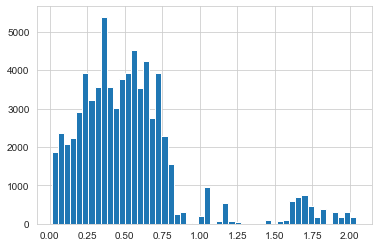

In [957]:
# Distribution of transformed distances, proxy for center of the basin
plt.hist(d, bins = 50);

In [1059]:
full_df.query("`max_rise` > 10")['surface_id'].unique()

array([], dtype=object)

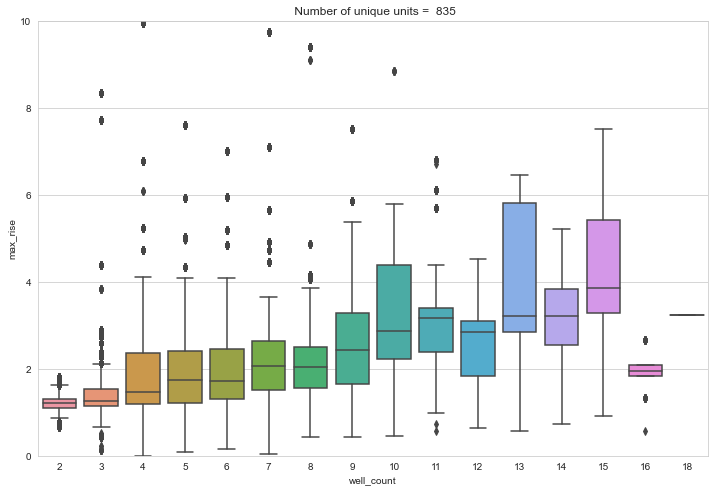

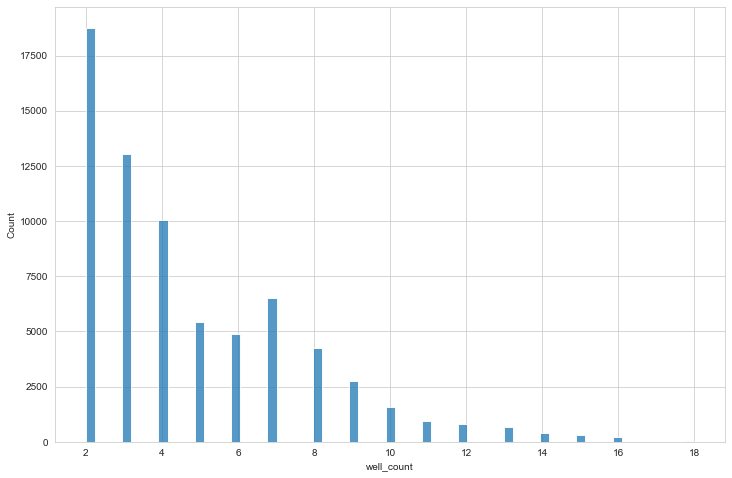

In [1060]:
plt.figure(figsize=(12,8))
sns.boxplot(data = full_df, x='well_count',  y ='max_rise')
plt.title(f" Number of unique units =  {full_df.query('well_count > 1')['surface_id'].nunique()}")
plt.ylim(0,10);

# Distribution of Well Counts
plt.figure(figsize=(12,8))
sns.histplot(data = full_df, x='well_count');
# plt.hist(full_df['well_count'], bins = 7);

In [1061]:
full_df.columns

Index(['state', 'surface_id', 'well_count', 'lat', 'lng', 'production_date',
       'monthly_oil', 'monthly_gas', 'monthly_water', 'monthly_liquid',
       'cum_liquid', 'monthly_wc', 'unit_proppant_ft', 'unit_total_proppant',
       'unit_stage_count', 'distance', 'max_rise', 'slopes', 'y', 'y_norm'],
      dtype='object')

In [1062]:
y_ = full_df['y']
y_norm_ = full_df['y_norm']
max_rise_ = full_df['max_rise']
d= full_df['distance']

In [1084]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD


scaler = StandardScaler()

poly = PolynomialFeatures()

regressor = LinearRegression()

dim_red = TruncatedSVD()




select_dist_model = Pipeline([
    ('select_dist', select_dist_features),
    ('scaler', scaler),
    ('poly', poly ),
#     ('dimensionality', dim_red),
    ('regressor', regressor)
])

target = y_

In [1085]:
from sklearn.model_selection import GridSearchCV

params = {}
params['poly__degree'] = [2, 3, 4]
# params['dimensionality__n_components'] = [x for x in range(2,6)]
# params['dimensionality__random_state'] = [17]       

grid = GridSearchCV(select_dist_model, params, cv=5, verbose=1)

In [1087]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_df, target, test_size=0.33, random_state=42)

In [1088]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   15.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('select_dist',
                                        Pipeline(steps=[('selector',
                                                         ColumnSelectTransformer(columns=['well_count',
                                                                                          'lat',
                                                                                          'lng',
                                                                                          'monthly_gas',
                                                                                          'monthly_liquid',
                                                                                          'cum_liquid',
                                                                                          'monthly_wc',
                                                                                          'unit_proppant_ft',
                            

In [1089]:
grid.best_estimator_

Pipeline(steps=[('select_dist',
                 Pipeline(steps=[('selector',
                                  ColumnSelectTransformer(columns=['well_count',
                                                                   'lat', 'lng',
                                                                   'monthly_gas',
                                                                   'monthly_liquid',
                                                                   'cum_liquid',
                                                                   'monthly_wc',
                                                                   'unit_proppant_ft',
                                                                   'unit_total_proppant',
                                                                   'unit_stage_count'])),
                                 ('distance',
                                  ColumnTransformer(transformers=[('keene_coord',
                                    

In [1090]:
grid.score(X_test, y_test)

0.3838186471293964

In [1097]:
scaler = StandardScaler()

poly = PolynomialFeatures(degree=2)

regressor = LinearRegression()

# dim_red = TruncatedSVD()




#reference coordinates to calc distance

select_dist_model = Pipeline([
    ('select_dist', select_dist_features),
    ('scaler', scaler),
    ('poly', poly ),
#     ('dim-red', dim_red),
    ('regressor', regressor)
])

target = y_

In [1098]:
select_dist_model.fit(X_train, y_train)

select_dist_model.score(X_test, y_test)

0.3838186471293964

In [1099]:
y_pred = select_dist_model.predict(X_test)

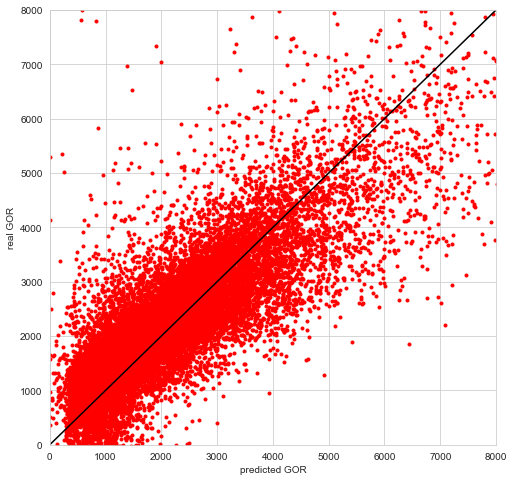

In [1101]:
plt.figure(figsize=(8,8))

plt.plot(y_test ,y_pred, 'r.')
plt.plot([0,8000] ,[0 , 8000], 'k')
plt.ylim(0,8000)
plt.xlim(0,8000)
plt.ylabel('real GOR')
plt.xlabel('predicted GOR')
plt.xlim(0,8000);

In [1071]:
#This will represent the importance of contributions

select = select_dist_model.named_steps['select_dist']
select

Pipeline(steps=[('selector',
                 ColumnSelectTransformer(columns=['well_count', 'lat', 'lng',
                                                  'monthly_gas',
                                                  'monthly_liquid',
                                                  'cum_liquid', 'monthly_wc',
                                                  'unit_proppant_ft',
                                                  'unit_total_proppant',
                                                  'unit_stage_count'])),
                ('distance',
                 ColumnTransformer(transformers=[('keene_coord',
                                                  DistTransformer(origin=(47.9834,
                                                                          -102.95)),
                                                  (1, 2)),
                                                 ('else', 'passthrough',
                                                  (0, 3, 4, 5, 6, 7, 8, 

In [1102]:
cols = ['distance','well_count','monthly_gas','monthly_liquid','cum_liquid','monthly_wc','unit_proppant_ft','unit_total_proppant','unit_stage_count']

select.transform(full_df)[0]

array([1.83514383e+00, 2.00000000e+00, 6.37171158e+02, 2.35461658e+03,
       1.63380655e+05, 5.20222000e-01, 4.26000000e+02, 3.56504000e+06,
       3.00000000e+01])

In [1103]:
#This will represent the importance of contributions

lr = select_dist_model.named_steps['regressor']


In [1104]:
len(lr.coef_)

55

In [1074]:
[(x[0], x[1]) for x in zip(cols, lr.coef_)]

[('distance', -121.35503806760823),
 ('well_count', -127.84582657618984),
 ('monthly_gas', 1372.3010808713489),
 ('monthly_liquid', -1243.3449247696778),
 ('cum_liquid', 348.7072536627345),
 ('monthly_wc', 394.881272572521),
 ('unit_proppant_ft', 353.3655348216617),
 ('unit_total_proppant', -455.41072301545483),
 ('unit_stage_count', 101.74860907284949)]

C:\Users\grellama\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


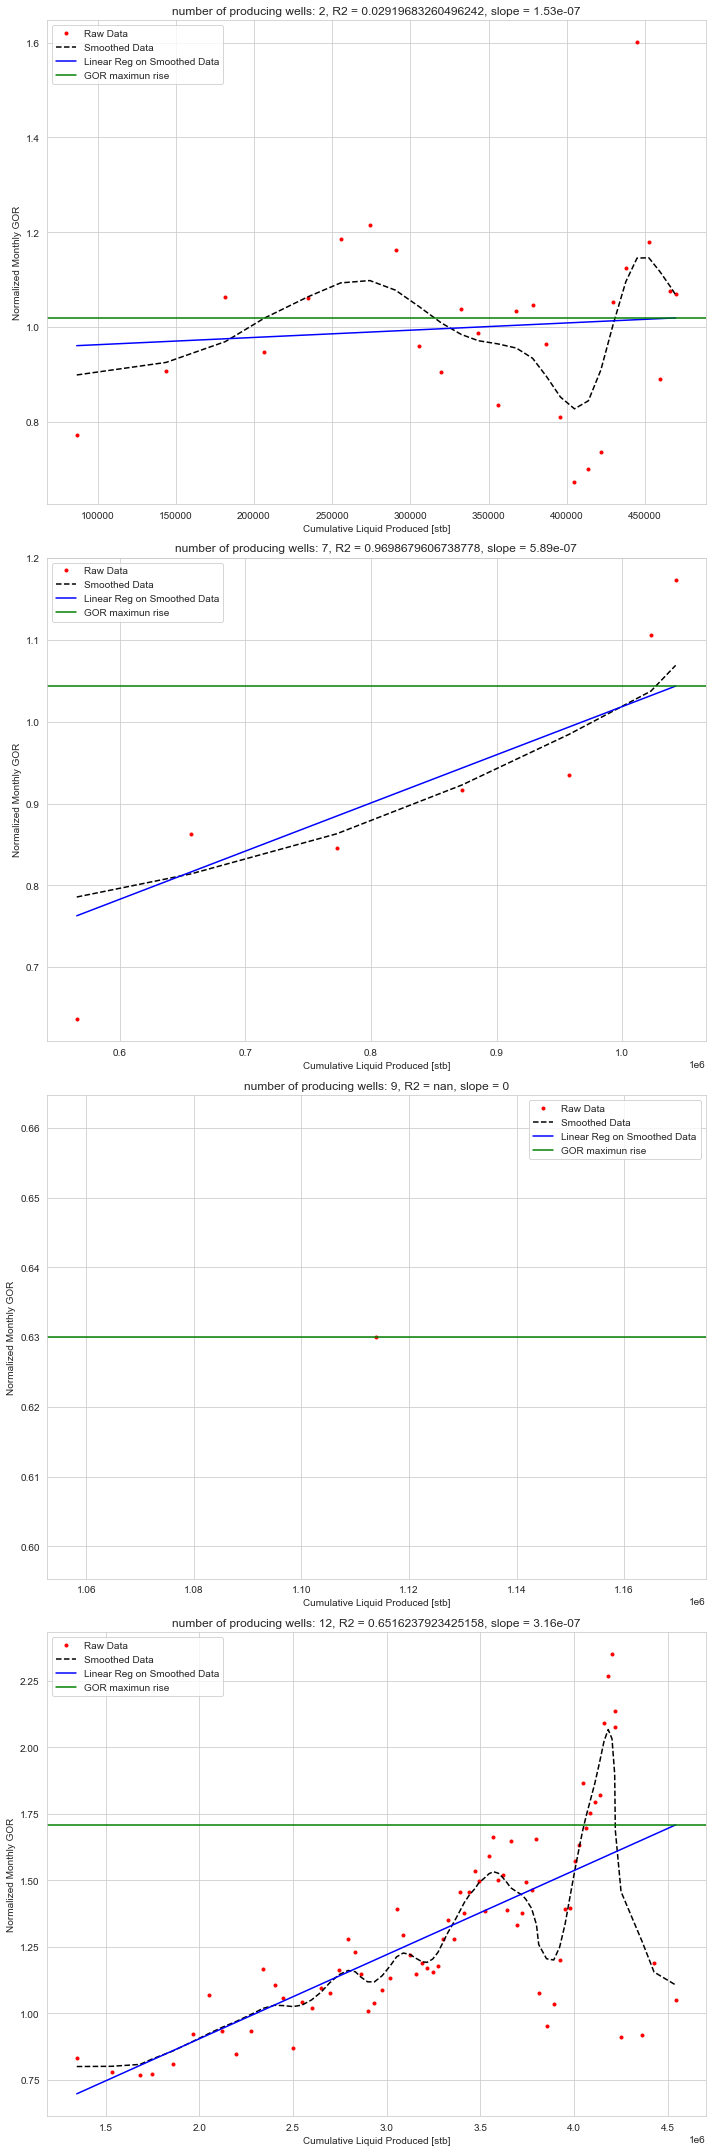

In [901]:
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d


fig, axes = plt.subplots(nrows = sections.ngroups, figsize = (10,30))

wc_lst = list(sections.groups.keys())
scores = []
for i in range(len(wc_lst)):
    data = sections.get_group(wc_lst[i])
    X_p = data['cum_liquid'].values
    y_p = data['y_norm'].values
    
    lr = LinearRegression(fit_intercept=True)
#     model = Pipeline([('poly', PolynomialFeatures(degree=1)),
#                       ('linear', LinearRegression(fit_intercept=True))])

    smooth = gaussian_filter1d(y_p, 2)
    lr.fit(X_p.reshape(-1, 1), smooth)
    y_pred = lr.predict(X_p.reshape(-1, 1))
    max_value = y_pred[-1:]
    axes[i].plot(X_p, y_p, 'r.', label = 'Raw Data')
    axes[i].plot(X_p, smooth, 'k--', label='Smoothed Data')
    axes[i].plot(X_p, y_pred, 'b-', label='Linear Reg on Smoothed Data')
    axes[i].axhline(y= max_value[0], color="green", label='GOR maximun rise')
    axes[i].set_ylabel('Normalized Monthly GOR')
    axes[i].set_xlabel('Cumulative Liquid Produced [stb]')
    axes[i].set_title("number of producing wells: {}, R2 = {}, slope = {:,.3g}".format(
        wc_lst[i], lr.score(X_p.reshape(-1, 1), smooth), lr.coef_[0])
    )
    axes[i].legend()


    
plt.tight_layout()


In [906]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter1d


# np.random.seed(0)

# # generate noisy data
# raw = np.cumsum(np.random.normal(5, 100, 1000))
# raw /= np.max(raw) # Normalizing here by the max, this is equivalent to raw = raw/np.max(raw)


# # smooth
# smooth = gaussian_filter1d(raw, 100)

# # compute second derivative
# smooth_d2 = np.gradient(np.gradient(smooth))


# # find switching points
# infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# # plot results
# plt.plot(raw, label='Noisy Data')
# plt.plot(smooth, label='Smoothed Data')
# plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
# for i, infl in enumerate(infls, 1):
#     plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
# plt.legend(bbox_to_anchor=(1.55, 1.0))